## GPS Spoofing Detection

### 1. load data and preprocess

In [1]:
# Load Data
import DataLoader
import os
import numpy as np
import config

A, B = DataLoader.load_image_pairs(path=config.SUZHOU_RESIZED) # or config.SWISS_RESIZED
assert A.shape[0]==B.shape[0]
n = A.shape[0]
print(A.shape, B.shape)

# Some configuration
feature_map_file_name = './mid_product/features_suzhou_res34_eval.h5'#'features_suzhou_res50.h5'
#feature_map_file_name = config.FULL_RESIZED_FEATURE
dst_file_name = './mid_product/dst_suzhou_res34_eval.npy'# 'dst_suzhou_res50.npy' 
# feature_shape = (512, 18, 26) # SWISS, resnet-18/34
feature_shape = (512, 17, 34) # SUZHOU, 1280x720, resnet-18/34
# feature_shape = (2048, 17, 34) # SUZHOU, resnet-50

(238, 720, 1280, 3) (238, 720, 1280, 3)


In [2]:
# Preprocess data by doing transformation
import torch

A = A.astype(np.float)/255.0
B = B.astype(np.float)/255.0 #.transpose(0,3,1,2)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
x_a = torch.from_numpy((A-mean)/std).permute(0,3,1,2).float()
x_b = torch.from_numpy((B-mean)/std).permute(0,3,1,2).float()
print(x_a.size(), x_b.size())

torch.Size([238, 3, 720, 1280]) torch.Size([238, 3, 720, 1280])


### 2. get feature maps

In [3]:
import torchvision.models as models
from torch import nn

pretrained_model = models.resnet34(pretrained=True)
feature_extractor = nn.Sequential(*list(pretrained_model.children())[:-1])
feature_extractor.eval()
for param in feature_extractor.parameters():
    param.requires_grad = False

In [4]:
# Generate feature map and save
import h5py

def h5_save(fname, f_a, f_b):
    '''save f_a and f_b as fname'''
    with h5py.File(fname,'w') as f:
        f.create_dataset('f_a', data=f_a)
        f.create_dataset('f_b', data=f_b)
    
def h5_read(fname):
    '''read fname and return f_a and f_b'''
    with h5py.File(fname,'r') as f:
        return f['f_a'][:], f['f_b'][:]

if not os.path.exists(feature_map_file_name):
    f_a = np.zeros((n,)+feature_shape)
    f_b = np.zeros((n,)+feature_shape)
    for i in range(n):
        print( "Generating feature maps of %d / %d th pair."%(i+1, n), end='\r')
        a = feature_extractor(x_a[i:i+1,:,:,:])
        b = feature_extractor(x_b[i:i+1,:,:,:])
        f_a[i] = a.detach().numpy()
        f_b[i] = b.detach().numpy()
    h5_save(feature_map_file_name, f_a, f_b)
else:
    print("Feature maps file already exists, we just read it.")
    f_a, f_b = h5_read(feature_map_file_name)

In [5]:
# compute distance between unpaird and paired images
print("A domain feature maps size:", f_a.shape)
dst=np.zeros((n,n))
for shift in range(n):
    for idx in range(n):
        a = f_a[idx:idx+1]
        b = f_b[(idx+shift)%n:(idx+shift)%n+1]
        dst[idx,shift] = np.linalg.norm(a - b)
        print('dst(idx,shift)(%d,%d)=%f' % (idx,shift,dst[idx,shift]))
np.save(dst_file_name, dst)

A domain feature maps size: (238, 512, 17, 34)
dst(idx,shift)(0,0)=837.754993
dst(idx,shift)(1,0)=667.760908
dst(idx,shift)(2,0)=667.614221
dst(idx,shift)(3,0)=572.453423
dst(idx,shift)(4,0)=603.433847
dst(idx,shift)(5,0)=380.178424
dst(idx,shift)(6,0)=376.791483
dst(idx,shift)(7,0)=442.229807
dst(idx,shift)(8,0)=991.029864
dst(idx,shift)(9,0)=744.076118
dst(idx,shift)(10,0)=703.996269
dst(idx,shift)(11,0)=509.542273
dst(idx,shift)(12,0)=502.749474
dst(idx,shift)(13,0)=485.263448
dst(idx,shift)(14,0)=486.449944
dst(idx,shift)(15,0)=410.809367
dst(idx,shift)(16,0)=398.472476
dst(idx,shift)(17,0)=427.416766
dst(idx,shift)(18,0)=534.341537
dst(idx,shift)(19,0)=433.056714
dst(idx,shift)(20,0)=530.312609
dst(idx,shift)(21,0)=489.178560
dst(idx,shift)(22,0)=480.751966
dst(idx,shift)(23,0)=509.245273
dst(idx,shift)(24,0)=446.858519
dst(idx,shift)(25,0)=464.013487
dst(idx,shift)(26,0)=451.420107
dst(idx,shift)(27,0)=518.439283
dst(idx,shift)(28,0)=481.342804
dst(idx,shift)(29,0)=497.237136
dst

dst(idx,shift)(185,1)=579.520375
dst(idx,shift)(186,1)=635.343849
dst(idx,shift)(187,1)=586.534638
dst(idx,shift)(188,1)=559.079611
dst(idx,shift)(189,1)=449.830195
dst(idx,shift)(190,1)=468.259768
dst(idx,shift)(191,1)=475.635452
dst(idx,shift)(192,1)=518.035594
dst(idx,shift)(193,1)=534.190237
dst(idx,shift)(194,1)=609.441120
dst(idx,shift)(195,1)=563.528135
dst(idx,shift)(196,1)=553.052528
dst(idx,shift)(197,1)=539.932297
dst(idx,shift)(198,1)=498.998990
dst(idx,shift)(199,1)=519.925925
dst(idx,shift)(200,1)=534.318607
dst(idx,shift)(201,1)=543.861153
dst(idx,shift)(202,1)=522.024013
dst(idx,shift)(203,1)=590.667289
dst(idx,shift)(204,1)=560.979346
dst(idx,shift)(205,1)=537.575972
dst(idx,shift)(206,1)=606.129107
dst(idx,shift)(207,1)=604.289537
dst(idx,shift)(208,1)=636.188019
dst(idx,shift)(209,1)=601.032789
dst(idx,shift)(210,1)=517.879664
dst(idx,shift)(211,1)=477.682506
dst(idx,shift)(212,1)=494.185997
dst(idx,shift)(213,1)=467.901443
dst(idx,shift)(214,1)=408.337391
dst(idx,sh

dst(idx,shift)(70,4)=558.584054
dst(idx,shift)(71,4)=511.868089
dst(idx,shift)(72,4)=633.932502
dst(idx,shift)(73,4)=658.843554
dst(idx,shift)(74,4)=620.011052
dst(idx,shift)(75,4)=463.891250
dst(idx,shift)(76,4)=613.062503
dst(idx,shift)(77,4)=624.661565
dst(idx,shift)(78,4)=572.190085
dst(idx,shift)(79,4)=579.058359
dst(idx,shift)(80,4)=566.726249
dst(idx,shift)(81,4)=617.640980
dst(idx,shift)(82,4)=673.238183
dst(idx,shift)(83,4)=702.318507
dst(idx,shift)(84,4)=644.384063
dst(idx,shift)(85,4)=610.090984
dst(idx,shift)(86,4)=586.641472
dst(idx,shift)(87,4)=575.079807
dst(idx,shift)(88,4)=583.044131
dst(idx,shift)(89,4)=573.637277
dst(idx,shift)(90,4)=556.618852
dst(idx,shift)(91,4)=539.618998
dst(idx,shift)(92,4)=551.196074
dst(idx,shift)(93,4)=672.723135
dst(idx,shift)(94,4)=614.640531
dst(idx,shift)(95,4)=611.150916
dst(idx,shift)(96,4)=627.629057
dst(idx,shift)(97,4)=539.758855
dst(idx,shift)(98,4)=586.701601
dst(idx,shift)(99,4)=570.851529
dst(idx,shift)(100,4)=566.383810
dst(idx

dst(idx,shift)(3,6)=611.887603
dst(idx,shift)(4,6)=788.611832
dst(idx,shift)(5,6)=460.038919
dst(idx,shift)(6,6)=426.744593
dst(idx,shift)(7,6)=491.843960
dst(idx,shift)(8,6)=1062.740907
dst(idx,shift)(9,6)=771.401040
dst(idx,shift)(10,6)=628.950399
dst(idx,shift)(11,6)=508.376396
dst(idx,shift)(12,6)=524.708939
dst(idx,shift)(13,6)=500.160544
dst(idx,shift)(14,6)=529.914421
dst(idx,shift)(15,6)=491.016918
dst(idx,shift)(16,6)=473.468542
dst(idx,shift)(17,6)=495.036088
dst(idx,shift)(18,6)=564.103715
dst(idx,shift)(19,6)=470.558264
dst(idx,shift)(20,6)=536.147420
dst(idx,shift)(21,6)=567.198266
dst(idx,shift)(22,6)=496.449871
dst(idx,shift)(23,6)=548.070019
dst(idx,shift)(24,6)=494.829893
dst(idx,shift)(25,6)=468.623344
dst(idx,shift)(26,6)=503.005061
dst(idx,shift)(27,6)=524.356474
dst(idx,shift)(28,6)=508.731667
dst(idx,shift)(29,6)=596.743451
dst(idx,shift)(30,6)=563.981034
dst(idx,shift)(31,6)=510.310277
dst(idx,shift)(32,6)=510.398352
dst(idx,shift)(33,6)=462.671781
dst(idx,shift)

dst(idx,shift)(175,7)=608.016065
dst(idx,shift)(176,7)=572.921601
dst(idx,shift)(177,7)=583.170095
dst(idx,shift)(178,7)=532.148009
dst(idx,shift)(179,7)=559.877298
dst(idx,shift)(180,7)=573.204797
dst(idx,shift)(181,7)=547.760110
dst(idx,shift)(182,7)=530.095507
dst(idx,shift)(183,7)=488.260337
dst(idx,shift)(184,7)=448.940490
dst(idx,shift)(185,7)=518.930065
dst(idx,shift)(186,7)=623.745934
dst(idx,shift)(187,7)=604.633027
dst(idx,shift)(188,7)=588.159782
dst(idx,shift)(189,7)=527.818463
dst(idx,shift)(190,7)=564.654999
dst(idx,shift)(191,7)=468.209402
dst(idx,shift)(192,7)=499.811202
dst(idx,shift)(193,7)=489.713274
dst(idx,shift)(194,7)=590.805148
dst(idx,shift)(195,7)=546.150397
dst(idx,shift)(196,7)=512.055597
dst(idx,shift)(197,7)=594.307313
dst(idx,shift)(198,7)=477.568506
dst(idx,shift)(199,7)=570.362756
dst(idx,shift)(200,7)=634.450013
dst(idx,shift)(201,7)=672.698270
dst(idx,shift)(202,7)=662.367528
dst(idx,shift)(203,7)=551.643064
dst(idx,shift)(204,7)=573.323686
dst(idx,sh

dst(idx,shift)(109,9)=475.694046
dst(idx,shift)(110,9)=449.081007
dst(idx,shift)(111,9)=491.100546
dst(idx,shift)(112,9)=503.315035
dst(idx,shift)(113,9)=494.465266
dst(idx,shift)(114,9)=579.037659
dst(idx,shift)(115,9)=641.827789
dst(idx,shift)(116,9)=620.661885
dst(idx,shift)(117,9)=529.988288
dst(idx,shift)(118,9)=501.046594
dst(idx,shift)(119,9)=451.536066
dst(idx,shift)(120,9)=595.749868
dst(idx,shift)(121,9)=620.979450
dst(idx,shift)(122,9)=609.600383
dst(idx,shift)(123,9)=515.128034
dst(idx,shift)(124,9)=616.140044
dst(idx,shift)(125,9)=532.309047
dst(idx,shift)(126,9)=542.160749
dst(idx,shift)(127,9)=528.460653
dst(idx,shift)(128,9)=505.041689
dst(idx,shift)(129,9)=507.394874
dst(idx,shift)(130,9)=576.430573
dst(idx,shift)(131,9)=614.362133
dst(idx,shift)(132,9)=486.849592
dst(idx,shift)(133,9)=597.870002
dst(idx,shift)(134,9)=552.033326
dst(idx,shift)(135,9)=592.638056
dst(idx,shift)(136,9)=592.002947
dst(idx,shift)(137,9)=607.762731
dst(idx,shift)(138,9)=633.914765
dst(idx,sh

dst(idx,shift)(43,11)=529.251849
dst(idx,shift)(44,11)=528.711575
dst(idx,shift)(45,11)=569.414336
dst(idx,shift)(46,11)=561.951578
dst(idx,shift)(47,11)=484.818879
dst(idx,shift)(48,11)=569.731520
dst(idx,shift)(49,11)=539.549023
dst(idx,shift)(50,11)=595.215926
dst(idx,shift)(51,11)=549.794741
dst(idx,shift)(52,11)=554.999702
dst(idx,shift)(53,11)=515.462841
dst(idx,shift)(54,11)=496.742020
dst(idx,shift)(55,11)=520.662074
dst(idx,shift)(56,11)=573.918817
dst(idx,shift)(57,11)=613.075669
dst(idx,shift)(58,11)=569.103540
dst(idx,shift)(59,11)=493.227891
dst(idx,shift)(60,11)=562.739706
dst(idx,shift)(61,11)=637.028047
dst(idx,shift)(62,11)=639.506407
dst(idx,shift)(63,11)=572.292360
dst(idx,shift)(64,11)=543.307405
dst(idx,shift)(65,11)=589.625826
dst(idx,shift)(66,11)=621.524512
dst(idx,shift)(67,11)=539.172832
dst(idx,shift)(68,11)=509.801773
dst(idx,shift)(69,11)=562.744193
dst(idx,shift)(70,11)=589.562488
dst(idx,shift)(71,11)=584.743084
dst(idx,shift)(72,11)=644.920354
dst(idx,sh

dst(idx,shift)(219,12)=573.117955
dst(idx,shift)(220,12)=612.208935
dst(idx,shift)(221,12)=620.966100
dst(idx,shift)(222,12)=634.183194
dst(idx,shift)(223,12)=645.069541
dst(idx,shift)(224,12)=551.652029
dst(idx,shift)(225,12)=442.235871
dst(idx,shift)(226,12)=880.525240
dst(idx,shift)(227,12)=575.337701
dst(idx,shift)(228,12)=529.485636
dst(idx,shift)(229,12)=514.193306
dst(idx,shift)(230,12)=613.919714
dst(idx,shift)(231,12)=562.107509
dst(idx,shift)(232,12)=570.305333
dst(idx,shift)(233,12)=576.898615
dst(idx,shift)(234,12)=817.742851
dst(idx,shift)(235,12)=567.430407
dst(idx,shift)(236,12)=744.318434
dst(idx,shift)(237,12)=548.804777
dst(idx,shift)(0,13)=659.508932
dst(idx,shift)(1,13)=654.937599
dst(idx,shift)(2,13)=678.063011
dst(idx,shift)(3,13)=625.486765
dst(idx,shift)(4,13)=638.181913
dst(idx,shift)(5,13)=486.728378
dst(idx,shift)(6,13)=455.098667
dst(idx,shift)(7,13)=519.719582
dst(idx,shift)(8,13)=1034.323829
dst(idx,shift)(9,13)=753.949112
dst(idx,shift)(10,13)=607.636067


dst(idx,shift)(153,14)=553.472059
dst(idx,shift)(154,14)=589.796688
dst(idx,shift)(155,14)=601.057306
dst(idx,shift)(156,14)=525.227768
dst(idx,shift)(157,14)=524.236706
dst(idx,shift)(158,14)=575.817849
dst(idx,shift)(159,14)=635.829622
dst(idx,shift)(160,14)=556.825545
dst(idx,shift)(161,14)=500.562038
dst(idx,shift)(162,14)=562.949464
dst(idx,shift)(163,14)=628.317350
dst(idx,shift)(164,14)=581.288394
dst(idx,shift)(165,14)=484.372762
dst(idx,shift)(166,14)=599.882116
dst(idx,shift)(167,14)=675.601877
dst(idx,shift)(168,14)=645.204732
dst(idx,shift)(169,14)=624.753977
dst(idx,shift)(170,14)=544.332864
dst(idx,shift)(171,14)=548.593469
dst(idx,shift)(172,14)=632.066196
dst(idx,shift)(173,14)=602.532589
dst(idx,shift)(174,14)=517.040677
dst(idx,shift)(175,14)=454.158286
dst(idx,shift)(176,14)=489.420812
dst(idx,shift)(177,14)=546.862205
dst(idx,shift)(178,14)=510.553043
dst(idx,shift)(179,14)=500.408840
dst(idx,shift)(180,14)=582.958257
dst(idx,shift)(181,14)=584.987973
dst(idx,shift)

dst(idx,shift)(47,16)=537.767162
dst(idx,shift)(48,16)=579.029052
dst(idx,shift)(49,16)=537.414889
dst(idx,shift)(50,16)=556.750966
dst(idx,shift)(51,16)=602.118622
dst(idx,shift)(52,16)=566.889720
dst(idx,shift)(53,16)=508.399776
dst(idx,shift)(54,16)=510.715445
dst(idx,shift)(55,16)=526.581105
dst(idx,shift)(56,16)=588.165039
dst(idx,shift)(57,16)=649.006114
dst(idx,shift)(58,16)=574.335597
dst(idx,shift)(59,16)=501.191914
dst(idx,shift)(60,16)=597.617431
dst(idx,shift)(61,16)=638.967544
dst(idx,shift)(62,16)=620.661762
dst(idx,shift)(63,16)=592.447153
dst(idx,shift)(64,16)=535.622488
dst(idx,shift)(65,16)=577.737967
dst(idx,shift)(66,16)=562.460610
dst(idx,shift)(67,16)=570.588316
dst(idx,shift)(68,16)=545.093429
dst(idx,shift)(69,16)=612.603091
dst(idx,shift)(70,16)=645.360930
dst(idx,shift)(71,16)=640.545342
dst(idx,shift)(72,16)=620.966803
dst(idx,shift)(73,16)=635.009794
dst(idx,shift)(74,16)=616.398416
dst(idx,shift)(75,16)=477.958629
dst(idx,shift)(76,16)=624.086539
dst(idx,sh

dst(idx,shift)(223,17)=551.645452
dst(idx,shift)(224,17)=527.694046
dst(idx,shift)(225,17)=561.020922
dst(idx,shift)(226,17)=515.220580
dst(idx,shift)(227,17)=481.955225
dst(idx,shift)(228,17)=500.263503
dst(idx,shift)(229,17)=852.632521
dst(idx,shift)(230,17)=565.090205
dst(idx,shift)(231,17)=724.635091
dst(idx,shift)(232,17)=570.397199
dst(idx,shift)(233,17)=554.608742
dst(idx,shift)(234,17)=619.707316
dst(idx,shift)(235,17)=591.751616
dst(idx,shift)(236,17)=543.703468
dst(idx,shift)(237,17)=553.371725
dst(idx,shift)(0,18)=639.433898
dst(idx,shift)(1,18)=644.866630
dst(idx,shift)(2,18)=698.064750
dst(idx,shift)(3,18)=636.100939
dst(idx,shift)(4,18)=619.415973
dst(idx,shift)(5,18)=445.573370
dst(idx,shift)(6,18)=440.128664
dst(idx,shift)(7,18)=501.068021
dst(idx,shift)(8,18)=1054.992329
dst(idx,shift)(9,18)=758.653020
dst(idx,shift)(10,18)=614.238554
dst(idx,shift)(11,18)=551.642149
dst(idx,shift)(12,18)=553.078846
dst(idx,shift)(13,18)=483.832367
dst(idx,shift)(14,18)=498.859241
dst(

dst(idx,shift)(185,19)=580.280570
dst(idx,shift)(186,19)=635.416441
dst(idx,shift)(187,19)=645.181561
dst(idx,shift)(188,19)=639.515530
dst(idx,shift)(189,19)=630.137698
dst(idx,shift)(190,19)=640.202188
dst(idx,shift)(191,19)=506.764634
dst(idx,shift)(192,19)=528.279290
dst(idx,shift)(193,19)=515.822593
dst(idx,shift)(194,19)=581.632840
dst(idx,shift)(195,19)=526.941230
dst(idx,shift)(196,19)=501.588112
dst(idx,shift)(197,19)=540.902910
dst(idx,shift)(198,19)=501.896925
dst(idx,shift)(199,19)=528.770920
dst(idx,shift)(200,19)=512.639703
dst(idx,shift)(201,19)=560.537321
dst(idx,shift)(202,19)=542.618163
dst(idx,shift)(203,19)=494.815788
dst(idx,shift)(204,19)=575.792403
dst(idx,shift)(205,19)=482.506438
dst(idx,shift)(206,19)=560.633389
dst(idx,shift)(207,19)=537.480155
dst(idx,shift)(208,19)=582.722568
dst(idx,shift)(209,19)=581.148989
dst(idx,shift)(210,19)=522.624718
dst(idx,shift)(211,19)=540.521909
dst(idx,shift)(212,19)=572.414673
dst(idx,shift)(213,19)=632.420815
dst(idx,shift)

dst(idx,shift)(80,22)=580.350529
dst(idx,shift)(81,22)=556.475707
dst(idx,shift)(82,22)=586.797601
dst(idx,shift)(83,22)=603.013018
dst(idx,shift)(84,22)=608.018537
dst(idx,shift)(85,22)=607.739772
dst(idx,shift)(86,22)=599.806440
dst(idx,shift)(87,22)=594.509887
dst(idx,shift)(88,22)=593.679212
dst(idx,shift)(89,22)=581.026449
dst(idx,shift)(90,22)=568.837010
dst(idx,shift)(91,22)=501.966810
dst(idx,shift)(92,22)=516.526968
dst(idx,shift)(93,22)=605.789961
dst(idx,shift)(94,22)=587.318772
dst(idx,shift)(95,22)=639.879873
dst(idx,shift)(96,22)=586.010087
dst(idx,shift)(97,22)=556.517579
dst(idx,shift)(98,22)=578.590785
dst(idx,shift)(99,22)=591.164879
dst(idx,shift)(100,22)=574.342132
dst(idx,shift)(101,22)=525.937526
dst(idx,shift)(102,22)=573.220812
dst(idx,shift)(103,22)=588.478253
dst(idx,shift)(104,22)=524.433765
dst(idx,shift)(105,22)=513.636386
dst(idx,shift)(106,22)=462.397823
dst(idx,shift)(107,22)=598.421608
dst(idx,shift)(108,22)=625.770156
dst(idx,shift)(109,22)=614.033193


dst(idx,shift)(135,24)=564.663982
dst(idx,shift)(136,24)=562.215869
dst(idx,shift)(137,24)=618.743598
dst(idx,shift)(138,24)=617.035667
dst(idx,shift)(139,24)=603.942565
dst(idx,shift)(140,24)=522.490102
dst(idx,shift)(141,24)=549.305304
dst(idx,shift)(142,24)=587.246724
dst(idx,shift)(143,24)=597.754060
dst(idx,shift)(144,24)=537.365943
dst(idx,shift)(145,24)=550.154502
dst(idx,shift)(146,24)=488.509936
dst(idx,shift)(147,24)=546.563412
dst(idx,shift)(148,24)=570.833399
dst(idx,shift)(149,24)=579.709181
dst(idx,shift)(150,24)=636.910578
dst(idx,shift)(151,24)=541.934643
dst(idx,shift)(152,24)=528.461654
dst(idx,shift)(153,24)=548.451988
dst(idx,shift)(154,24)=611.317240
dst(idx,shift)(155,24)=567.419373
dst(idx,shift)(156,24)=600.685683
dst(idx,shift)(157,24)=593.843414
dst(idx,shift)(158,24)=643.688794
dst(idx,shift)(159,24)=688.027569
dst(idx,shift)(160,24)=619.939814
dst(idx,shift)(161,24)=533.746588
dst(idx,shift)(162,24)=575.834700
dst(idx,shift)(163,24)=652.206208
dst(idx,shift)

dst(idx,shift)(141,26)=562.242939
dst(idx,shift)(142,26)=599.845923
dst(idx,shift)(143,26)=607.296011
dst(idx,shift)(144,26)=551.041307
dst(idx,shift)(145,26)=536.011232
dst(idx,shift)(146,26)=584.391216
dst(idx,shift)(147,26)=522.026497
dst(idx,shift)(148,26)=532.133262
dst(idx,shift)(149,26)=568.329981
dst(idx,shift)(150,26)=643.323450
dst(idx,shift)(151,26)=560.673753
dst(idx,shift)(152,26)=551.645457
dst(idx,shift)(153,26)=516.128046
dst(idx,shift)(154,26)=652.385189
dst(idx,shift)(155,26)=675.120021
dst(idx,shift)(156,26)=646.465271
dst(idx,shift)(157,26)=573.612423
dst(idx,shift)(158,26)=590.371974
dst(idx,shift)(159,26)=630.950476
dst(idx,shift)(160,26)=584.205993
dst(idx,shift)(161,26)=557.583039
dst(idx,shift)(162,26)=558.783695
dst(idx,shift)(163,26)=635.788776
dst(idx,shift)(164,26)=571.091847
dst(idx,shift)(165,26)=470.867215
dst(idx,shift)(166,26)=539.472924
dst(idx,shift)(167,26)=593.324206
dst(idx,shift)(168,26)=574.833728
dst(idx,shift)(169,26)=594.416614
dst(idx,shift)

dst(idx,shift)(74,28)=597.230203
dst(idx,shift)(75,28)=503.001018
dst(idx,shift)(76,28)=624.222791
dst(idx,shift)(77,28)=580.428390
dst(idx,shift)(78,28)=502.866617
dst(idx,shift)(79,28)=463.984013
dst(idx,shift)(80,28)=540.645782
dst(idx,shift)(81,28)=537.350247
dst(idx,shift)(82,28)=557.655523
dst(idx,shift)(83,28)=616.384737
dst(idx,shift)(84,28)=603.139504
dst(idx,shift)(85,28)=608.038179
dst(idx,shift)(86,28)=581.803800
dst(idx,shift)(87,28)=584.449276
dst(idx,shift)(88,28)=614.863834
dst(idx,shift)(89,28)=640.510801
dst(idx,shift)(90,28)=545.904147
dst(idx,shift)(91,28)=502.387208
dst(idx,shift)(92,28)=502.004961
dst(idx,shift)(93,28)=511.621418
dst(idx,shift)(94,28)=498.785717
dst(idx,shift)(95,28)=571.101961
dst(idx,shift)(96,28)=612.292363
dst(idx,shift)(97,28)=577.526291
dst(idx,shift)(98,28)=590.011427
dst(idx,shift)(99,28)=605.112760
dst(idx,shift)(100,28)=560.560620
dst(idx,shift)(101,28)=606.646218
dst(idx,shift)(102,28)=600.969217
dst(idx,shift)(103,28)=583.049106
dst(id

dst(idx,shift)(65,30)=516.681363
dst(idx,shift)(66,30)=551.356634
dst(idx,shift)(67,30)=660.231292
dst(idx,shift)(68,30)=588.512477
dst(idx,shift)(69,30)=630.867386
dst(idx,shift)(70,30)=608.541597
dst(idx,shift)(71,30)=519.821184
dst(idx,shift)(72,30)=624.227938
dst(idx,shift)(73,30)=626.171018
dst(idx,shift)(74,30)=602.250946
dst(idx,shift)(75,30)=491.853641
dst(idx,shift)(76,30)=606.008171
dst(idx,shift)(77,30)=588.184783
dst(idx,shift)(78,30)=491.998109
dst(idx,shift)(79,30)=463.626308
dst(idx,shift)(80,30)=535.199812
dst(idx,shift)(81,30)=563.144316
dst(idx,shift)(82,30)=573.840520
dst(idx,shift)(83,30)=592.454970
dst(idx,shift)(84,30)=621.392345
dst(idx,shift)(85,30)=594.329454
dst(idx,shift)(86,30)=612.080426
dst(idx,shift)(87,30)=647.656221
dst(idx,shift)(88,30)=582.359286
dst(idx,shift)(89,30)=584.243182
dst(idx,shift)(90,30)=567.482292
dst(idx,shift)(91,30)=534.329410
dst(idx,shift)(92,30)=497.919815
dst(idx,shift)(93,30)=504.076212
dst(idx,shift)(94,30)=590.868108
dst(idx,sh

dst(idx,shift)(61,32)=637.345724
dst(idx,shift)(62,32)=598.693878
dst(idx,shift)(63,32)=613.832574
dst(idx,shift)(64,32)=573.643975
dst(idx,shift)(65,32)=648.695815
dst(idx,shift)(66,32)=610.865288
dst(idx,shift)(67,32)=599.388001
dst(idx,shift)(68,32)=560.853088
dst(idx,shift)(69,32)=586.464463
dst(idx,shift)(70,32)=582.029366
dst(idx,shift)(71,32)=481.400362
dst(idx,shift)(72,32)=614.600011
dst(idx,shift)(73,32)=638.495565
dst(idx,shift)(74,32)=602.921013
dst(idx,shift)(75,32)=472.424902
dst(idx,shift)(76,32)=617.787462
dst(idx,shift)(77,32)=585.444167
dst(idx,shift)(78,32)=491.357519
dst(idx,shift)(79,32)=486.726618
dst(idx,shift)(80,32)=519.806626
dst(idx,shift)(81,32)=559.414127
dst(idx,shift)(82,32)=601.710026
dst(idx,shift)(83,32)=653.620550
dst(idx,shift)(84,32)=637.786421
dst(idx,shift)(85,32)=667.230785
dst(idx,shift)(86,32)=583.397839
dst(idx,shift)(87,32)=604.532033
dst(idx,shift)(88,32)=587.880401
dst(idx,shift)(89,32)=594.456068
dst(idx,shift)(90,32)=579.036387
dst(idx,sh

dst(idx,shift)(8,34)=1057.010504
dst(idx,shift)(9,34)=781.296983
dst(idx,shift)(10,34)=616.341991
dst(idx,shift)(11,34)=532.258064
dst(idx,shift)(12,34)=522.944951
dst(idx,shift)(13,34)=492.017825
dst(idx,shift)(14,34)=537.420055
dst(idx,shift)(15,34)=464.666255
dst(idx,shift)(16,34)=466.473145
dst(idx,shift)(17,34)=551.119411
dst(idx,shift)(18,34)=543.303759
dst(idx,shift)(19,34)=489.973742
dst(idx,shift)(20,34)=565.071891
dst(idx,shift)(21,34)=550.087000
dst(idx,shift)(22,34)=537.887783
dst(idx,shift)(23,34)=575.922239
dst(idx,shift)(24,34)=471.177976
dst(idx,shift)(25,34)=492.188453
dst(idx,shift)(26,34)=536.311246
dst(idx,shift)(27,34)=579.450189
dst(idx,shift)(28,34)=558.767387
dst(idx,shift)(29,34)=588.565306
dst(idx,shift)(30,34)=553.352604
dst(idx,shift)(31,34)=505.906977
dst(idx,shift)(32,34)=501.758260
dst(idx,shift)(33,34)=518.605104
dst(idx,shift)(34,34)=537.835934
dst(idx,shift)(35,34)=564.268162
dst(idx,shift)(36,34)=526.318739
dst(idx,shift)(37,34)=535.264718
dst(idx,shi

dst(idx,shift)(184,35)=453.022903
dst(idx,shift)(185,35)=503.523652
dst(idx,shift)(186,35)=625.188693
dst(idx,shift)(187,35)=575.418572
dst(idx,shift)(188,35)=576.762915
dst(idx,shift)(189,35)=520.991946
dst(idx,shift)(190,35)=467.727718
dst(idx,shift)(191,35)=491.950120
dst(idx,shift)(192,35)=519.471080
dst(idx,shift)(193,35)=493.145329
dst(idx,shift)(194,35)=590.636870
dst(idx,shift)(195,35)=562.763093
dst(idx,shift)(196,35)=575.342345
dst(idx,shift)(197,35)=648.446652
dst(idx,shift)(198,35)=656.000882
dst(idx,shift)(199,35)=637.022641
dst(idx,shift)(200,35)=668.787634
dst(idx,shift)(201,35)=609.887384
dst(idx,shift)(202,35)=560.205547
dst(idx,shift)(203,35)=876.587019
dst(idx,shift)(204,35)=581.095092
dst(idx,shift)(205,35)=508.286527
dst(idx,shift)(206,35)=581.815629
dst(idx,shift)(207,35)=593.018865
dst(idx,shift)(208,35)=606.208322
dst(idx,shift)(209,35)=607.057956
dst(idx,shift)(210,35)=504.558918
dst(idx,shift)(211,35)=811.459654
dst(idx,shift)(212,35)=499.765864
dst(idx,shift)

dst(idx,shift)(198,36)=644.336284
dst(idx,shift)(199,36)=633.654856
dst(idx,shift)(200,36)=573.536332
dst(idx,shift)(201,36)=585.991410
dst(idx,shift)(202,36)=896.467355
dst(idx,shift)(203,36)=594.648258
dst(idx,shift)(204,36)=558.238666
dst(idx,shift)(205,36)=490.584894
dst(idx,shift)(206,36)=622.514643
dst(idx,shift)(207,36)=569.001956
dst(idx,shift)(208,36)=595.134642
dst(idx,shift)(209,36)=603.584222
dst(idx,shift)(210,36)=810.525886
dst(idx,shift)(211,36)=509.237001
dst(idx,shift)(212,36)=744.547577
dst(idx,shift)(213,36)=494.756079
dst(idx,shift)(214,36)=433.631709
dst(idx,shift)(215,36)=469.147421
dst(idx,shift)(216,36)=444.913898
dst(idx,shift)(217,36)=532.522963
dst(idx,shift)(218,36)=528.024304
dst(idx,shift)(219,36)=483.343711
dst(idx,shift)(220,36)=499.695079
dst(idx,shift)(221,36)=460.031833
dst(idx,shift)(222,36)=489.584589
dst(idx,shift)(223,36)=543.893181
dst(idx,shift)(224,36)=513.634383
dst(idx,shift)(225,36)=450.494173
dst(idx,shift)(226,36)=526.489429
dst(idx,shift)

dst(idx,shift)(154,38)=609.394344
dst(idx,shift)(155,38)=598.444362
dst(idx,shift)(156,38)=569.983824
dst(idx,shift)(157,38)=531.838008
dst(idx,shift)(158,38)=573.631216
dst(idx,shift)(159,38)=667.957069
dst(idx,shift)(160,38)=584.248153
dst(idx,shift)(161,38)=522.996246
dst(idx,shift)(162,38)=570.042096
dst(idx,shift)(163,38)=642.289051
dst(idx,shift)(164,38)=563.311791
dst(idx,shift)(165,38)=496.300700
dst(idx,shift)(166,38)=577.323572
dst(idx,shift)(167,38)=581.474020
dst(idx,shift)(168,38)=608.210480
dst(idx,shift)(169,38)=637.913901
dst(idx,shift)(170,38)=614.615128
dst(idx,shift)(171,38)=661.022321
dst(idx,shift)(172,38)=664.054483
dst(idx,shift)(173,38)=606.517607
dst(idx,shift)(174,38)=513.419169
dst(idx,shift)(175,38)=485.571521
dst(idx,shift)(176,38)=481.868149
dst(idx,shift)(177,38)=550.212906
dst(idx,shift)(178,38)=504.971885
dst(idx,shift)(179,38)=507.852410
dst(idx,shift)(180,38)=533.968245
dst(idx,shift)(181,38)=554.880656
dst(idx,shift)(182,38)=546.963154
dst(idx,shift)

dst(idx,shift)(91,40)=630.171835
dst(idx,shift)(92,40)=486.120641
dst(idx,shift)(93,40)=614.714619
dst(idx,shift)(94,40)=489.445251
dst(idx,shift)(95,40)=540.111603
dst(idx,shift)(96,40)=581.239239
dst(idx,shift)(97,40)=532.358023
dst(idx,shift)(98,40)=538.041893
dst(idx,shift)(99,40)=584.863703
dst(idx,shift)(100,40)=557.786417
dst(idx,shift)(101,40)=502.093262
dst(idx,shift)(102,40)=524.752532
dst(idx,shift)(103,40)=501.628057
dst(idx,shift)(104,40)=519.901231
dst(idx,shift)(105,40)=502.204936
dst(idx,shift)(106,40)=474.943453
dst(idx,shift)(107,40)=505.571011
dst(idx,shift)(108,40)=517.557311
dst(idx,shift)(109,40)=467.727038
dst(idx,shift)(110,40)=536.358451
dst(idx,shift)(111,40)=482.923676
dst(idx,shift)(112,40)=480.696622
dst(idx,shift)(113,40)=479.726044
dst(idx,shift)(114,40)=588.052048
dst(idx,shift)(115,40)=620.907968
dst(idx,shift)(116,40)=583.143852
dst(idx,shift)(117,40)=521.190549
dst(idx,shift)(118,40)=490.418542
dst(idx,shift)(119,40)=508.944673
dst(idx,shift)(120,40)=

dst(idx,shift)(18,42)=541.489812
dst(idx,shift)(19,42)=597.229294
dst(idx,shift)(20,42)=595.493481
dst(idx,shift)(21,42)=543.603953
dst(idx,shift)(22,42)=500.174018
dst(idx,shift)(23,42)=507.766518
dst(idx,shift)(24,42)=463.264514
dst(idx,shift)(25,42)=538.075719
dst(idx,shift)(26,42)=562.560487
dst(idx,shift)(27,42)=542.925541
dst(idx,shift)(28,42)=522.935241
dst(idx,shift)(29,42)=560.562158
dst(idx,shift)(30,42)=619.795831
dst(idx,shift)(31,42)=588.989764
dst(idx,shift)(32,42)=535.541709
dst(idx,shift)(33,42)=473.944349
dst(idx,shift)(34,42)=583.943907
dst(idx,shift)(35,42)=639.522922
dst(idx,shift)(36,42)=517.537110
dst(idx,shift)(37,42)=501.355114
dst(idx,shift)(38,42)=535.312294
dst(idx,shift)(39,42)=580.556383
dst(idx,shift)(40,42)=578.588315
dst(idx,shift)(41,42)=593.079580
dst(idx,shift)(42,42)=537.152030
dst(idx,shift)(43,42)=591.621984
dst(idx,shift)(44,42)=634.637232
dst(idx,shift)(45,42)=667.724294
dst(idx,shift)(46,42)=566.942196
dst(idx,shift)(47,42)=538.584318
dst(idx,sh

dst(idx,shift)(58,44)=560.654484
dst(idx,shift)(59,44)=475.069046
dst(idx,shift)(60,44)=559.445591
dst(idx,shift)(61,44)=643.679343
dst(idx,shift)(62,44)=587.982055
dst(idx,shift)(63,44)=590.959049
dst(idx,shift)(64,44)=529.741180
dst(idx,shift)(65,44)=507.110231
dst(idx,shift)(66,44)=481.124443
dst(idx,shift)(67,44)=534.005768
dst(idx,shift)(68,44)=524.245377
dst(idx,shift)(69,44)=560.090382
dst(idx,shift)(70,44)=555.173593
dst(idx,shift)(71,44)=579.179519
dst(idx,shift)(72,44)=618.916571
dst(idx,shift)(73,44)=685.635428
dst(idx,shift)(74,44)=607.525213
dst(idx,shift)(75,44)=476.191843
dst(idx,shift)(76,44)=628.914563
dst(idx,shift)(77,44)=602.857124
dst(idx,shift)(78,44)=510.786154
dst(idx,shift)(79,44)=488.812257
dst(idx,shift)(80,44)=619.326862
dst(idx,shift)(81,44)=629.337473
dst(idx,shift)(82,44)=594.055697
dst(idx,shift)(83,44)=637.614837
dst(idx,shift)(84,44)=610.949081
dst(idx,shift)(85,44)=619.111041
dst(idx,shift)(86,44)=602.495275
dst(idx,shift)(87,44)=627.793641
dst(idx,sh

dst(idx,shift)(30,46)=626.847064
dst(idx,shift)(31,46)=643.710417
dst(idx,shift)(32,46)=478.184536
dst(idx,shift)(33,46)=450.993401
dst(idx,shift)(34,46)=488.172644
dst(idx,shift)(35,46)=573.799762
dst(idx,shift)(36,46)=586.561983
dst(idx,shift)(37,46)=590.222913
dst(idx,shift)(38,46)=548.621288
dst(idx,shift)(39,46)=593.890182
dst(idx,shift)(40,46)=628.511380
dst(idx,shift)(41,46)=663.421111
dst(idx,shift)(42,46)=552.668874
dst(idx,shift)(43,46)=552.112692
dst(idx,shift)(44,46)=522.264700
dst(idx,shift)(45,46)=502.683621
dst(idx,shift)(46,46)=492.209534
dst(idx,shift)(47,46)=517.664105
dst(idx,shift)(48,46)=566.081450
dst(idx,shift)(49,46)=570.097107
dst(idx,shift)(50,46)=582.128970
dst(idx,shift)(51,46)=680.902163
dst(idx,shift)(52,46)=601.638250
dst(idx,shift)(53,46)=580.226721
dst(idx,shift)(54,46)=550.451494
dst(idx,shift)(55,46)=528.833045
dst(idx,shift)(56,46)=584.302085
dst(idx,shift)(57,46)=587.974190
dst(idx,shift)(58,46)=544.610760
dst(idx,shift)(59,46)=468.314279
dst(idx,sh

dst(idx,shift)(194,47)=602.401813
dst(idx,shift)(195,47)=593.056257
dst(idx,shift)(196,47)=520.515193
dst(idx,shift)(197,47)=549.405064
dst(idx,shift)(198,47)=506.015044
dst(idx,shift)(199,47)=848.804442
dst(idx,shift)(200,47)=558.458576
dst(idx,shift)(201,47)=798.732541
dst(idx,shift)(202,47)=555.892864
dst(idx,shift)(203,47)=512.741616
dst(idx,shift)(204,47)=571.001860
dst(idx,shift)(205,47)=423.158377
dst(idx,shift)(206,47)=598.343591
dst(idx,shift)(207,47)=563.848202
dst(idx,shift)(208,47)=578.369991
dst(idx,shift)(209,47)=611.587623
dst(idx,shift)(210,47)=502.029924
dst(idx,shift)(211,47)=503.585218
dst(idx,shift)(212,47)=509.202231
dst(idx,shift)(213,47)=501.473740
dst(idx,shift)(214,47)=450.889525
dst(idx,shift)(215,47)=443.350551
dst(idx,shift)(216,47)=430.748619
dst(idx,shift)(217,47)=544.226149
dst(idx,shift)(218,47)=562.084897
dst(idx,shift)(219,47)=497.898301
dst(idx,shift)(220,47)=483.789750
dst(idx,shift)(221,47)=479.997797
dst(idx,shift)(222,47)=459.175196
dst(idx,shift)

dst(idx,shift)(134,49)=614.924629
dst(idx,shift)(135,49)=609.073292
dst(idx,shift)(136,49)=590.635414
dst(idx,shift)(137,49)=627.193042
dst(idx,shift)(138,49)=626.412494
dst(idx,shift)(139,49)=576.427664
dst(idx,shift)(140,49)=478.488085
dst(idx,shift)(141,49)=550.206209
dst(idx,shift)(142,49)=591.322654
dst(idx,shift)(143,49)=596.303513
dst(idx,shift)(144,49)=531.041938
dst(idx,shift)(145,49)=541.708935
dst(idx,shift)(146,49)=531.100667
dst(idx,shift)(147,49)=532.623794
dst(idx,shift)(148,49)=553.774960
dst(idx,shift)(149,49)=567.888310
dst(idx,shift)(150,49)=643.579185
dst(idx,shift)(151,49)=584.809986
dst(idx,shift)(152,49)=542.199941
dst(idx,shift)(153,49)=535.866478
dst(idx,shift)(154,49)=606.576476
dst(idx,shift)(155,49)=639.629422
dst(idx,shift)(156,49)=525.539972
dst(idx,shift)(157,49)=553.930299
dst(idx,shift)(158,49)=612.633876
dst(idx,shift)(159,49)=696.548494
dst(idx,shift)(160,49)=661.896634
dst(idx,shift)(161,49)=545.502813
dst(idx,shift)(162,49)=586.766576
dst(idx,shift)

dst(idx,shift)(68,51)=497.410060
dst(idx,shift)(69,51)=579.774955
dst(idx,shift)(70,51)=556.859510
dst(idx,shift)(71,51)=517.506391
dst(idx,shift)(72,51)=616.405939
dst(idx,shift)(73,51)=664.593353
dst(idx,shift)(74,51)=650.846596
dst(idx,shift)(75,51)=532.077059
dst(idx,shift)(76,51)=645.866287
dst(idx,shift)(77,51)=584.713251
dst(idx,shift)(78,51)=611.030122
dst(idx,shift)(79,51)=605.712931
dst(idx,shift)(80,51)=628.273200
dst(idx,shift)(81,51)=558.179211
dst(idx,shift)(82,51)=653.995262
dst(idx,shift)(83,51)=586.660078
dst(idx,shift)(84,51)=577.857316
dst(idx,shift)(85,51)=606.450550
dst(idx,shift)(86,51)=565.971437
dst(idx,shift)(87,51)=552.289812
dst(idx,shift)(88,51)=588.777268
dst(idx,shift)(89,51)=553.906829
dst(idx,shift)(90,51)=544.869324
dst(idx,shift)(91,51)=518.646356
dst(idx,shift)(92,51)=500.888021
dst(idx,shift)(93,51)=507.218650
dst(idx,shift)(94,51)=495.630752
dst(idx,shift)(95,51)=564.273576
dst(idx,shift)(96,51)=592.664751
dst(idx,shift)(97,51)=534.909812
dst(idx,sh

dst(idx,shift)(91,53)=530.016145
dst(idx,shift)(92,53)=496.100935
dst(idx,shift)(93,53)=488.500468
dst(idx,shift)(94,53)=516.484754
dst(idx,shift)(95,53)=561.063101
dst(idx,shift)(96,53)=556.660290
dst(idx,shift)(97,53)=553.811741
dst(idx,shift)(98,53)=565.565075
dst(idx,shift)(99,53)=583.555438
dst(idx,shift)(100,53)=560.267393
dst(idx,shift)(101,53)=536.388204
dst(idx,shift)(102,53)=520.492969
dst(idx,shift)(103,53)=495.179526
dst(idx,shift)(104,53)=488.338198
dst(idx,shift)(105,53)=499.716922
dst(idx,shift)(106,53)=497.784852
dst(idx,shift)(107,53)=486.250423
dst(idx,shift)(108,53)=561.046172
dst(idx,shift)(109,53)=498.372840
dst(idx,shift)(110,53)=520.541037
dst(idx,shift)(111,53)=473.185862
dst(idx,shift)(112,53)=487.287142
dst(idx,shift)(113,53)=491.499216
dst(idx,shift)(114,53)=594.065883
dst(idx,shift)(115,53)=625.119130
dst(idx,shift)(116,53)=614.146674
dst(idx,shift)(117,53)=502.079203
dst(idx,shift)(118,53)=549.648568
dst(idx,shift)(119,53)=574.074269
dst(idx,shift)(120,53)=

dst(idx,shift)(38,55)=534.855309
dst(idx,shift)(39,55)=503.419937
dst(idx,shift)(40,55)=544.954167
dst(idx,shift)(41,55)=552.715383
dst(idx,shift)(42,55)=647.163026
dst(idx,shift)(43,55)=616.724703
dst(idx,shift)(44,55)=593.436829
dst(idx,shift)(45,55)=599.633198
dst(idx,shift)(46,55)=518.390911
dst(idx,shift)(47,55)=519.431320
dst(idx,shift)(48,55)=567.365771
dst(idx,shift)(49,55)=538.151673
dst(idx,shift)(50,55)=541.143239
dst(idx,shift)(51,55)=569.678444
dst(idx,shift)(52,55)=521.142403
dst(idx,shift)(53,55)=497.770519
dst(idx,shift)(54,55)=481.151639
dst(idx,shift)(55,55)=502.803318
dst(idx,shift)(56,55)=572.956720
dst(idx,shift)(57,55)=600.592691
dst(idx,shift)(58,55)=521.975160
dst(idx,shift)(59,55)=481.835885
dst(idx,shift)(60,55)=593.134099
dst(idx,shift)(61,55)=633.048552
dst(idx,shift)(62,55)=676.960691
dst(idx,shift)(63,55)=596.471808
dst(idx,shift)(64,55)=543.877433
dst(idx,shift)(65,55)=514.224031
dst(idx,shift)(66,55)=511.216028
dst(idx,shift)(67,55)=541.674929
dst(idx,sh

dst(idx,shift)(180,56)=547.385585
dst(idx,shift)(181,56)=564.914459
dst(idx,shift)(182,56)=841.460126
dst(idx,shift)(183,56)=571.478580
dst(idx,shift)(184,56)=544.158766
dst(idx,shift)(185,56)=552.800560
dst(idx,shift)(186,56)=673.762948
dst(idx,shift)(187,56)=601.198866
dst(idx,shift)(188,56)=572.408524
dst(idx,shift)(189,56)=474.682280
dst(idx,shift)(190,56)=877.655768
dst(idx,shift)(191,56)=514.148494
dst(idx,shift)(192,56)=770.447876
dst(idx,shift)(193,56)=503.027263
dst(idx,shift)(194,56)=582.804335
dst(idx,shift)(195,56)=559.657382
dst(idx,shift)(196,56)=519.755023
dst(idx,shift)(197,56)=552.543509
dst(idx,shift)(198,56)=479.024648
dst(idx,shift)(199,56)=509.765954
dst(idx,shift)(200,56)=552.720154
dst(idx,shift)(201,56)=579.932471
dst(idx,shift)(202,56)=577.764618
dst(idx,shift)(203,56)=548.558883
dst(idx,shift)(204,56)=544.486624
dst(idx,shift)(205,56)=451.213861
dst(idx,shift)(206,56)=596.883435
dst(idx,shift)(207,56)=551.262998
dst(idx,shift)(208,56)=591.219281
dst(idx,shift)

dst(idx,shift)(106,58)=488.452335
dst(idx,shift)(107,58)=501.341746
dst(idx,shift)(108,58)=552.948223
dst(idx,shift)(109,58)=511.640289
dst(idx,shift)(110,58)=478.347827
dst(idx,shift)(111,58)=503.012633
dst(idx,shift)(112,58)=471.437826
dst(idx,shift)(113,58)=535.622201
dst(idx,shift)(114,58)=629.905269
dst(idx,shift)(115,58)=636.841665
dst(idx,shift)(116,58)=583.564086
dst(idx,shift)(117,58)=508.166832
dst(idx,shift)(118,58)=474.762368
dst(idx,shift)(119,58)=508.541467
dst(idx,shift)(120,58)=524.272836
dst(idx,shift)(121,58)=498.653387
dst(idx,shift)(122,58)=590.404284
dst(idx,shift)(123,58)=637.255465
dst(idx,shift)(124,58)=616.738673
dst(idx,shift)(125,58)=628.171204
dst(idx,shift)(126,58)=569.132666
dst(idx,shift)(127,58)=536.044146
dst(idx,shift)(128,58)=547.726967
dst(idx,shift)(129,58)=551.608024
dst(idx,shift)(130,58)=579.452903
dst(idx,shift)(131,58)=610.107929
dst(idx,shift)(132,58)=452.708386
dst(idx,shift)(133,58)=619.425124
dst(idx,shift)(134,58)=556.238302
dst(idx,shift)

dst(idx,shift)(96,60)=591.534264
dst(idx,shift)(97,60)=541.829401
dst(idx,shift)(98,60)=573.327795
dst(idx,shift)(99,60)=577.380927
dst(idx,shift)(100,60)=558.600857
dst(idx,shift)(101,60)=518.922359
dst(idx,shift)(102,60)=522.580039
dst(idx,shift)(103,60)=498.695927
dst(idx,shift)(104,60)=476.268135
dst(idx,shift)(105,60)=486.024092
dst(idx,shift)(106,60)=488.730800
dst(idx,shift)(107,60)=522.362048
dst(idx,shift)(108,60)=554.693260
dst(idx,shift)(109,60)=518.563844
dst(idx,shift)(110,60)=471.910084
dst(idx,shift)(111,60)=526.399678
dst(idx,shift)(112,60)=561.561418
dst(idx,shift)(113,60)=518.239180
dst(idx,shift)(114,60)=568.903019
dst(idx,shift)(115,60)=606.430239
dst(idx,shift)(116,60)=582.590899
dst(idx,shift)(117,60)=527.666716
dst(idx,shift)(118,60)=499.625606
dst(idx,shift)(119,60)=439.627944
dst(idx,shift)(120,60)=581.847770
dst(idx,shift)(121,60)=631.728754
dst(idx,shift)(122,60)=609.462570
dst(idx,shift)(123,60)=577.179987
dst(idx,shift)(124,60)=573.177933
dst(idx,shift)(125

dst(idx,shift)(26,62)=573.137474
dst(idx,shift)(27,62)=560.118768
dst(idx,shift)(28,62)=519.262125
dst(idx,shift)(29,62)=527.941170
dst(idx,shift)(30,62)=557.408584
dst(idx,shift)(31,62)=475.318780
dst(idx,shift)(32,62)=482.115805
dst(idx,shift)(33,62)=517.388730
dst(idx,shift)(34,62)=539.361865
dst(idx,shift)(35,62)=683.373886
dst(idx,shift)(36,62)=609.629261
dst(idx,shift)(37,62)=592.585981
dst(idx,shift)(38,62)=603.285934
dst(idx,shift)(39,62)=529.101235
dst(idx,shift)(40,62)=543.242631
dst(idx,shift)(41,62)=487.494798
dst(idx,shift)(42,62)=491.727596
dst(idx,shift)(43,62)=514.773853
dst(idx,shift)(44,62)=509.114139
dst(idx,shift)(45,62)=493.769011
dst(idx,shift)(46,62)=510.696308
dst(idx,shift)(47,62)=499.967314
dst(idx,shift)(48,62)=574.226012
dst(idx,shift)(49,62)=549.288882
dst(idx,shift)(50,62)=533.508148
dst(idx,shift)(51,62)=572.150513
dst(idx,shift)(52,62)=544.349432
dst(idx,shift)(53,62)=571.838608
dst(idx,shift)(54,62)=556.398086
dst(idx,shift)(55,62)=590.638962
dst(idx,sh

dst(idx,shift)(203,63)=546.440551
dst(idx,shift)(204,63)=581.582805
dst(idx,shift)(205,63)=478.403393
dst(idx,shift)(206,63)=584.221340
dst(idx,shift)(207,63)=563.096192
dst(idx,shift)(208,63)=598.351447
dst(idx,shift)(209,63)=599.310212
dst(idx,shift)(210,63)=591.616655
dst(idx,shift)(211,63)=518.299988
dst(idx,shift)(212,63)=515.161261
dst(idx,shift)(213,63)=514.837150
dst(idx,shift)(214,63)=457.450692
dst(idx,shift)(215,63)=472.562908
dst(idx,shift)(216,63)=477.091893
dst(idx,shift)(217,63)=527.751577
dst(idx,shift)(218,63)=556.563708
dst(idx,shift)(219,63)=515.146449
dst(idx,shift)(220,63)=474.824014
dst(idx,shift)(221,63)=480.227402
dst(idx,shift)(222,63)=487.666066
dst(idx,shift)(223,63)=541.840969
dst(idx,shift)(224,63)=496.204003
dst(idx,shift)(225,63)=454.895993
dst(idx,shift)(226,63)=578.337029
dst(idx,shift)(227,63)=541.798544
dst(idx,shift)(228,63)=502.347295
dst(idx,shift)(229,63)=518.639169
dst(idx,shift)(230,63)=574.996009
dst(idx,shift)(231,63)=535.342493
dst(idx,shift)

dst(idx,shift)(142,65)=643.339791
dst(idx,shift)(143,65)=659.682739
dst(idx,shift)(144,65)=636.900372
dst(idx,shift)(145,65)=541.023348
dst(idx,shift)(146,65)=505.061209
dst(idx,shift)(147,65)=508.063654
dst(idx,shift)(148,65)=527.060799
dst(idx,shift)(149,65)=577.952075
dst(idx,shift)(150,65)=661.534096
dst(idx,shift)(151,65)=581.222380
dst(idx,shift)(152,65)=518.966380
dst(idx,shift)(153,65)=542.685214
dst(idx,shift)(154,65)=611.438362
dst(idx,shift)(155,65)=597.697169
dst(idx,shift)(156,65)=536.743822
dst(idx,shift)(157,65)=478.309325
dst(idx,shift)(158,65)=544.152602
dst(idx,shift)(159,65)=651.805104
dst(idx,shift)(160,65)=588.044363
dst(idx,shift)(161,65)=496.175067
dst(idx,shift)(162,65)=556.848067
dst(idx,shift)(163,65)=642.302086
dst(idx,shift)(164,65)=581.278652
dst(idx,shift)(165,65)=552.088913
dst(idx,shift)(166,65)=582.046779
dst(idx,shift)(167,65)=675.809595
dst(idx,shift)(168,65)=661.758064
dst(idx,shift)(169,65)=673.789902
dst(idx,shift)(170,65)=651.332489
dst(idx,shift)

dst(idx,shift)(80,67)=552.301299
dst(idx,shift)(81,67)=521.229581
dst(idx,shift)(82,67)=572.609791
dst(idx,shift)(83,67)=632.776453
dst(idx,shift)(84,67)=616.346430
dst(idx,shift)(85,67)=605.540884
dst(idx,shift)(86,67)=580.714706
dst(idx,shift)(87,67)=600.056803
dst(idx,shift)(88,67)=596.447185
dst(idx,shift)(89,67)=568.404080
dst(idx,shift)(90,67)=575.989214
dst(idx,shift)(91,67)=509.452881
dst(idx,shift)(92,67)=510.520011
dst(idx,shift)(93,67)=493.512480
dst(idx,shift)(94,67)=492.446295
dst(idx,shift)(95,67)=558.917607
dst(idx,shift)(96,67)=597.558395
dst(idx,shift)(97,67)=535.019652
dst(idx,shift)(98,67)=574.336558
dst(idx,shift)(99,67)=588.212174
dst(idx,shift)(100,67)=578.009212
dst(idx,shift)(101,67)=491.355319
dst(idx,shift)(102,67)=549.905349
dst(idx,shift)(103,67)=475.104662
dst(idx,shift)(104,67)=528.515508
dst(idx,shift)(105,67)=561.886472
dst(idx,shift)(106,67)=507.910042
dst(idx,shift)(107,67)=496.195569
dst(idx,shift)(108,67)=524.499537
dst(idx,shift)(109,67)=490.885268


dst(idx,shift)(19,69)=556.316709
dst(idx,shift)(20,69)=584.340697
dst(idx,shift)(21,69)=556.952379
dst(idx,shift)(22,69)=480.709809
dst(idx,shift)(23,69)=497.341829
dst(idx,shift)(24,69)=449.704263
dst(idx,shift)(25,69)=466.204485
dst(idx,shift)(26,69)=555.962388
dst(idx,shift)(27,69)=576.166168
dst(idx,shift)(28,69)=660.010445
dst(idx,shift)(29,69)=638.030599
dst(idx,shift)(30,69)=615.459300
dst(idx,shift)(31,69)=584.346718
dst(idx,shift)(32,69)=519.124306
dst(idx,shift)(33,69)=521.292088
dst(idx,shift)(34,69)=473.529377
dst(idx,shift)(35,69)=550.255887
dst(idx,shift)(36,69)=511.354791
dst(idx,shift)(37,69)=510.510013
dst(idx,shift)(38,69)=534.462911
dst(idx,shift)(39,69)=521.408854
dst(idx,shift)(40,69)=488.318696
dst(idx,shift)(41,69)=470.712385
dst(idx,shift)(42,69)=492.266542
dst(idx,shift)(43,69)=506.239872
dst(idx,shift)(44,69)=501.757009
dst(idx,shift)(45,69)=519.093729
dst(idx,shift)(46,69)=600.122239
dst(idx,shift)(47,69)=575.162315
dst(idx,shift)(48,69)=655.865317
dst(idx,sh

dst(idx,shift)(228,70)=502.939317
dst(idx,shift)(229,70)=594.241764
dst(idx,shift)(230,70)=586.501891
dst(idx,shift)(231,70)=544.293957
dst(idx,shift)(232,70)=559.922447
dst(idx,shift)(233,70)=570.088666
dst(idx,shift)(234,70)=607.094888
dst(idx,shift)(235,70)=628.960110
dst(idx,shift)(236,70)=565.805930
dst(idx,shift)(237,70)=562.777853
dst(idx,shift)(0,71)=630.699427
dst(idx,shift)(1,71)=631.349165
dst(idx,shift)(2,71)=685.081679
dst(idx,shift)(3,71)=617.351588
dst(idx,shift)(4,71)=619.119909
dst(idx,shift)(5,71)=596.166588
dst(idx,shift)(6,71)=640.565645
dst(idx,shift)(7,71)=498.049019
dst(idx,shift)(8,71)=1055.637512
dst(idx,shift)(9,71)=749.191434
dst(idx,shift)(10,71)=627.340449
dst(idx,shift)(11,71)=608.156135
dst(idx,shift)(12,71)=585.355817
dst(idx,shift)(13,71)=516.244382
dst(idx,shift)(14,71)=592.825264
dst(idx,shift)(15,71)=609.642305
dst(idx,shift)(16,71)=647.491417
dst(idx,shift)(17,71)=572.834106
dst(idx,shift)(18,71)=545.003535
dst(idx,shift)(19,71)=495.913419
dst(idx,s

dst(idx,shift)(160,72)=656.041310
dst(idx,shift)(161,72)=640.109666
dst(idx,shift)(162,72)=665.491864
dst(idx,shift)(163,72)=712.801105
dst(idx,shift)(164,72)=596.816090
dst(idx,shift)(165,72)=520.545464
dst(idx,shift)(166,72)=880.249625
dst(idx,shift)(167,72)=632.950797
dst(idx,shift)(168,72)=576.377260
dst(idx,shift)(169,72)=547.096866
dst(idx,shift)(170,72)=576.784847
dst(idx,shift)(171,72)=556.788850
dst(idx,shift)(172,72)=634.694917
dst(idx,shift)(173,72)=576.886565
dst(idx,shift)(174,72)=860.862143
dst(idx,shift)(175,72)=497.295402
dst(idx,shift)(176,72)=748.022654
dst(idx,shift)(177,72)=547.784702
dst(idx,shift)(178,72)=497.959433
dst(idx,shift)(179,72)=512.820719
dst(idx,shift)(180,72)=519.953264
dst(idx,shift)(181,72)=563.293386
dst(idx,shift)(182,72)=534.851738
dst(idx,shift)(183,72)=478.167334
dst(idx,shift)(184,72)=516.087905
dst(idx,shift)(185,72)=525.761588
dst(idx,shift)(186,72)=666.171037
dst(idx,shift)(187,72)=604.789280
dst(idx,shift)(188,72)=564.680188
dst(idx,shift)

dst(idx,shift)(95,74)=577.134526
dst(idx,shift)(96,74)=574.946687
dst(idx,shift)(97,74)=581.222148
dst(idx,shift)(98,74)=623.066290
dst(idx,shift)(99,74)=606.705324
dst(idx,shift)(100,74)=561.282825
dst(idx,shift)(101,74)=517.396446
dst(idx,shift)(102,74)=515.011374
dst(idx,shift)(103,74)=513.738917
dst(idx,shift)(104,74)=495.853274
dst(idx,shift)(105,74)=469.326801
dst(idx,shift)(106,74)=572.103774
dst(idx,shift)(107,74)=617.806763
dst(idx,shift)(108,74)=642.540334
dst(idx,shift)(109,74)=581.299562
dst(idx,shift)(110,74)=502.393074
dst(idx,shift)(111,74)=504.517225
dst(idx,shift)(112,74)=528.692655
dst(idx,shift)(113,74)=539.928549
dst(idx,shift)(114,74)=527.557217
dst(idx,shift)(115,74)=616.031690
dst(idx,shift)(116,74)=598.127184
dst(idx,shift)(117,74)=507.685775
dst(idx,shift)(118,74)=452.386739
dst(idx,shift)(119,74)=444.387253
dst(idx,shift)(120,74)=554.225185
dst(idx,shift)(121,74)=581.092979
dst(idx,shift)(122,74)=521.974917
dst(idx,shift)(123,74)=575.347609
dst(idx,shift)(124,

dst(idx,shift)(211,75)=535.538519
dst(idx,shift)(212,75)=465.390315
dst(idx,shift)(213,75)=495.402655
dst(idx,shift)(214,75)=538.459163
dst(idx,shift)(215,75)=507.134041
dst(idx,shift)(216,75)=467.987485
dst(idx,shift)(217,75)=538.590812
dst(idx,shift)(218,75)=562.855296
dst(idx,shift)(219,75)=541.498396
dst(idx,shift)(220,75)=553.974929
dst(idx,shift)(221,75)=475.148811
dst(idx,shift)(222,75)=478.672577
dst(idx,shift)(223,75)=539.588699
dst(idx,shift)(224,75)=607.215261
dst(idx,shift)(225,75)=539.512976
dst(idx,shift)(226,75)=542.538651
dst(idx,shift)(227,75)=515.422966
dst(idx,shift)(228,75)=499.153712
dst(idx,shift)(229,75)=486.464602
dst(idx,shift)(230,75)=604.853960
dst(idx,shift)(231,75)=587.658036
dst(idx,shift)(232,75)=570.819993
dst(idx,shift)(233,75)=570.966632
dst(idx,shift)(234,75)=604.748399
dst(idx,shift)(235,75)=583.843190
dst(idx,shift)(236,75)=612.409984
dst(idx,shift)(237,75)=542.393234
dst(idx,shift)(0,76)=651.554276
dst(idx,shift)(1,76)=666.147885
dst(idx,shift)(2,7

dst(idx,shift)(149,77)=563.613543
dst(idx,shift)(150,77)=646.931540
dst(idx,shift)(151,77)=567.495286
dst(idx,shift)(152,77)=516.885666
dst(idx,shift)(153,77)=572.473943
dst(idx,shift)(154,77)=632.357382
dst(idx,shift)(155,77)=670.899337
dst(idx,shift)(156,77)=667.117295
dst(idx,shift)(157,77)=625.847031
dst(idx,shift)(158,77)=651.456628
dst(idx,shift)(159,77)=676.078935
dst(idx,shift)(160,77)=582.668093
dst(idx,shift)(161,77)=877.394761
dst(idx,shift)(162,77)=597.377165
dst(idx,shift)(163,77)=638.622261
dst(idx,shift)(164,77)=579.549362
dst(idx,shift)(165,77)=584.759030
dst(idx,shift)(166,77)=541.729406
dst(idx,shift)(167,77)=588.905790
dst(idx,shift)(168,77)=531.509777
dst(idx,shift)(169,77)=854.125437
dst(idx,shift)(170,77)=519.899671
dst(idx,shift)(171,77)=791.644122
dst(idx,shift)(172,77)=628.680127
dst(idx,shift)(173,77)=561.573252
dst(idx,shift)(174,77)=503.073741
dst(idx,shift)(175,77)=466.336657
dst(idx,shift)(176,77)=482.937748
dst(idx,shift)(177,77)=542.761620
dst(idx,shift)

dst(idx,shift)(81,79)=557.829177
dst(idx,shift)(82,79)=576.955956
dst(idx,shift)(83,79)=602.866951
dst(idx,shift)(84,79)=592.624382
dst(idx,shift)(85,79)=610.059851
dst(idx,shift)(86,79)=590.525916
dst(idx,shift)(87,79)=583.258874
dst(idx,shift)(88,79)=608.343866
dst(idx,shift)(89,79)=567.852437
dst(idx,shift)(90,79)=580.647813
dst(idx,shift)(91,79)=487.396361
dst(idx,shift)(92,79)=537.704376
dst(idx,shift)(93,79)=550.686416
dst(idx,shift)(94,79)=525.335082
dst(idx,shift)(95,79)=547.898335
dst(idx,shift)(96,79)=573.202265
dst(idx,shift)(97,79)=550.296090
dst(idx,shift)(98,79)=569.683451
dst(idx,shift)(99,79)=610.742760
dst(idx,shift)(100,79)=560.261955
dst(idx,shift)(101,79)=597.836059
dst(idx,shift)(102,79)=561.017222
dst(idx,shift)(103,79)=582.737257
dst(idx,shift)(104,79)=573.891810
dst(idx,shift)(105,79)=519.291435
dst(idx,shift)(106,79)=514.678258
dst(idx,shift)(107,79)=543.669029
dst(idx,shift)(108,79)=580.322741
dst(idx,shift)(109,79)=519.776887
dst(idx,shift)(110,79)=453.659670

dst(idx,shift)(170,80)=481.305131
dst(idx,shift)(171,80)=547.550392
dst(idx,shift)(172,80)=631.609182
dst(idx,shift)(173,80)=573.734636
dst(idx,shift)(174,80)=484.346414
dst(idx,shift)(175,80)=460.193593
dst(idx,shift)(176,80)=499.139970
dst(idx,shift)(177,80)=553.261512
dst(idx,shift)(178,80)=525.346370
dst(idx,shift)(179,80)=543.957975
dst(idx,shift)(180,80)=525.834344
dst(idx,shift)(181,80)=555.352781
dst(idx,shift)(182,80)=557.202517
dst(idx,shift)(183,80)=480.568282
dst(idx,shift)(184,80)=497.582900
dst(idx,shift)(185,80)=591.248091
dst(idx,shift)(186,80)=635.798026
dst(idx,shift)(187,80)=621.816662
dst(idx,shift)(188,80)=592.678503
dst(idx,shift)(189,80)=465.779009
dst(idx,shift)(190,80)=506.018954
dst(idx,shift)(191,80)=474.073839
dst(idx,shift)(192,80)=511.115716
dst(idx,shift)(193,80)=570.409543
dst(idx,shift)(194,80)=610.129484
dst(idx,shift)(195,80)=564.742303
dst(idx,shift)(196,80)=528.798719
dst(idx,shift)(197,80)=552.915486
dst(idx,shift)(198,80)=519.550493
dst(idx,shift)

dst(idx,shift)(48,82)=630.711817
dst(idx,shift)(49,82)=609.283873
dst(idx,shift)(50,82)=547.539996
dst(idx,shift)(51,82)=600.533959
dst(idx,shift)(52,82)=529.471787
dst(idx,shift)(53,82)=494.789036
dst(idx,shift)(54,82)=515.629918
dst(idx,shift)(55,82)=524.834047
dst(idx,shift)(56,82)=538.775401
dst(idx,shift)(57,82)=590.164650
dst(idx,shift)(58,82)=542.038543
dst(idx,shift)(59,82)=482.683957
dst(idx,shift)(60,82)=549.887325
dst(idx,shift)(61,82)=618.279532
dst(idx,shift)(62,82)=614.757225
dst(idx,shift)(63,82)=590.175503
dst(idx,shift)(64,82)=536.923782
dst(idx,shift)(65,82)=533.022175
dst(idx,shift)(66,82)=480.158977
dst(idx,shift)(67,82)=522.463652
dst(idx,shift)(68,82)=576.796414
dst(idx,shift)(69,82)=581.188650
dst(idx,shift)(70,82)=533.683683
dst(idx,shift)(71,82)=494.171636
dst(idx,shift)(72,82)=627.667010
dst(idx,shift)(73,82)=650.500522
dst(idx,shift)(74,82)=601.717478
dst(idx,shift)(75,82)=512.307480
dst(idx,shift)(76,82)=614.613614
dst(idx,shift)(77,82)=579.884031
dst(idx,sh

dst(idx,shift)(63,84)=598.290471
dst(idx,shift)(64,84)=527.368445
dst(idx,shift)(65,84)=482.925890
dst(idx,shift)(66,84)=535.580096
dst(idx,shift)(67,84)=561.489919
dst(idx,shift)(68,84)=510.072949
dst(idx,shift)(69,84)=556.943434
dst(idx,shift)(70,84)=549.454836
dst(idx,shift)(71,84)=508.733516
dst(idx,shift)(72,84)=608.202107
dst(idx,shift)(73,84)=640.285062
dst(idx,shift)(74,84)=608.289059
dst(idx,shift)(75,84)=525.127707
dst(idx,shift)(76,84)=598.785826
dst(idx,shift)(77,84)=605.613299
dst(idx,shift)(78,84)=515.058609
dst(idx,shift)(79,84)=514.931234
dst(idx,shift)(80,84)=533.204045
dst(idx,shift)(81,84)=550.609261
dst(idx,shift)(82,84)=580.638528
dst(idx,shift)(83,84)=621.142584
dst(idx,shift)(84,84)=605.951651
dst(idx,shift)(85,84)=630.433941
dst(idx,shift)(86,84)=583.671134
dst(idx,shift)(87,84)=597.471445
dst(idx,shift)(88,84)=642.367311
dst(idx,shift)(89,84)=602.928367
dst(idx,shift)(90,84)=553.874008
dst(idx,shift)(91,84)=494.535108
dst(idx,shift)(92,84)=504.139334
dst(idx,sh

dst(idx,shift)(198,85)=517.858602
dst(idx,shift)(199,85)=530.403786
dst(idx,shift)(200,85)=537.092085
dst(idx,shift)(201,85)=608.513881
dst(idx,shift)(202,85)=552.158661
dst(idx,shift)(203,85)=527.690611
dst(idx,shift)(204,85)=572.224957
dst(idx,shift)(205,85)=518.554253
dst(idx,shift)(206,85)=600.269781
dst(idx,shift)(207,85)=571.686539
dst(idx,shift)(208,85)=597.655005
dst(idx,shift)(209,85)=573.545912
dst(idx,shift)(210,85)=558.326985
dst(idx,shift)(211,85)=501.278892
dst(idx,shift)(212,85)=485.465050
dst(idx,shift)(213,85)=550.974738
dst(idx,shift)(214,85)=590.333608
dst(idx,shift)(215,85)=546.948728
dst(idx,shift)(216,85)=547.521045
dst(idx,shift)(217,85)=537.140333
dst(idx,shift)(218,85)=538.236994
dst(idx,shift)(219,85)=487.503786
dst(idx,shift)(220,85)=532.217512
dst(idx,shift)(221,85)=526.709036
dst(idx,shift)(222,85)=503.394158
dst(idx,shift)(223,85)=523.537937
dst(idx,shift)(224,85)=522.460947
dst(idx,shift)(225,85)=575.551257
dst(idx,shift)(226,85)=574.019606
dst(idx,shift)

dst(idx,shift)(106,87)=492.753220
dst(idx,shift)(107,87)=529.207240
dst(idx,shift)(108,87)=575.408186
dst(idx,shift)(109,87)=511.129121
dst(idx,shift)(110,87)=559.100256
dst(idx,shift)(111,87)=468.938046
dst(idx,shift)(112,87)=489.422677
dst(idx,shift)(113,87)=479.420787
dst(idx,shift)(114,87)=589.538671
dst(idx,shift)(115,87)=616.463800
dst(idx,shift)(116,87)=582.746592
dst(idx,shift)(117,87)=566.960530
dst(idx,shift)(118,87)=424.604862
dst(idx,shift)(119,87)=559.831381
dst(idx,shift)(120,87)=607.962218
dst(idx,shift)(121,87)=624.742045
dst(idx,shift)(122,87)=626.788196
dst(idx,shift)(123,87)=538.398598
dst(idx,shift)(124,87)=569.930057
dst(idx,shift)(125,87)=592.757409
dst(idx,shift)(126,87)=553.108894
dst(idx,shift)(127,87)=502.091918
dst(idx,shift)(128,87)=470.173556
dst(idx,shift)(129,87)=553.362863
dst(idx,shift)(130,87)=558.748803
dst(idx,shift)(131,87)=614.960343
dst(idx,shift)(132,87)=452.447156
dst(idx,shift)(133,87)=617.298055
dst(idx,shift)(134,87)=549.519981
dst(idx,shift)

dst(idx,shift)(17,89)=492.263175
dst(idx,shift)(18,89)=524.238062
dst(idx,shift)(19,89)=507.788781
dst(idx,shift)(20,89)=539.329429
dst(idx,shift)(21,89)=543.015182
dst(idx,shift)(22,89)=496.222079
dst(idx,shift)(23,89)=501.076284
dst(idx,shift)(24,89)=451.566045
dst(idx,shift)(25,89)=493.708008
dst(idx,shift)(26,89)=596.105390
dst(idx,shift)(27,89)=582.582782
dst(idx,shift)(28,89)=630.554759
dst(idx,shift)(29,89)=523.219411
dst(idx,shift)(30,89)=553.403634
dst(idx,shift)(31,89)=481.027745
dst(idx,shift)(32,89)=513.937950
dst(idx,shift)(33,89)=452.135626
dst(idx,shift)(34,89)=479.776099
dst(idx,shift)(35,89)=617.668466
dst(idx,shift)(36,89)=601.060262
dst(idx,shift)(37,89)=531.671343
dst(idx,shift)(38,89)=564.635256
dst(idx,shift)(39,89)=505.868800
dst(idx,shift)(40,89)=599.682388
dst(idx,shift)(41,89)=599.255116
dst(idx,shift)(42,89)=604.714042
dst(idx,shift)(43,89)=512.839146
dst(idx,shift)(44,89)=608.925774
dst(idx,shift)(45,89)=525.040367
dst(idx,shift)(46,89)=519.135422
dst(idx,sh

dst(idx,shift)(160,90)=560.138336
dst(idx,shift)(161,90)=498.933752
dst(idx,shift)(162,90)=555.011764
dst(idx,shift)(163,90)=657.723793
dst(idx,shift)(164,90)=568.886524
dst(idx,shift)(165,90)=492.309790
dst(idx,shift)(166,90)=544.784917
dst(idx,shift)(167,90)=606.973889
dst(idx,shift)(168,90)=576.045751
dst(idx,shift)(169,90)=588.592924
dst(idx,shift)(170,90)=511.015616
dst(idx,shift)(171,90)=556.401657
dst(idx,shift)(172,90)=647.532841
dst(idx,shift)(173,90)=567.777746
dst(idx,shift)(174,90)=531.411456
dst(idx,shift)(175,90)=534.954329
dst(idx,shift)(176,90)=492.305455
dst(idx,shift)(177,90)=581.633535
dst(idx,shift)(178,90)=531.415888
dst(idx,shift)(179,90)=499.425615
dst(idx,shift)(180,90)=528.292672
dst(idx,shift)(181,90)=551.271298
dst(idx,shift)(182,90)=530.080872
dst(idx,shift)(183,90)=546.329393
dst(idx,shift)(184,90)=505.918354
dst(idx,shift)(185,90)=556.465490
dst(idx,shift)(186,90)=637.320035
dst(idx,shift)(187,90)=606.196672
dst(idx,shift)(188,90)=585.210805
dst(idx,shift)

dst(idx,shift)(84,92)=605.695648
dst(idx,shift)(85,92)=602.856241
dst(idx,shift)(86,92)=610.932234
dst(idx,shift)(87,92)=581.955087
dst(idx,shift)(88,92)=623.307556
dst(idx,shift)(89,92)=634.428731
dst(idx,shift)(90,92)=648.492207
dst(idx,shift)(91,92)=588.545231
dst(idx,shift)(92,92)=524.728600
dst(idx,shift)(93,92)=519.132073
dst(idx,shift)(94,92)=541.942335
dst(idx,shift)(95,92)=588.058628
dst(idx,shift)(96,92)=582.098041
dst(idx,shift)(97,92)=535.423100
dst(idx,shift)(98,92)=577.239321
dst(idx,shift)(99,92)=587.667523
dst(idx,shift)(100,92)=566.351179
dst(idx,shift)(101,92)=516.044001
dst(idx,shift)(102,92)=528.780334
dst(idx,shift)(103,92)=539.440986
dst(idx,shift)(104,92)=528.291632
dst(idx,shift)(105,92)=553.820676
dst(idx,shift)(106,92)=464.231955
dst(idx,shift)(107,92)=497.388331
dst(idx,shift)(108,92)=560.233486
dst(idx,shift)(109,92)=505.895557
dst(idx,shift)(110,92)=482.063108
dst(idx,shift)(111,92)=479.455730
dst(idx,shift)(112,92)=533.610865
dst(idx,shift)(113,92)=473.471

dst(idx,shift)(236,93)=513.647075
dst(idx,shift)(237,93)=541.563103
dst(idx,shift)(0,94)=612.622156
dst(idx,shift)(1,94)=648.564843
dst(idx,shift)(2,94)=690.703919
dst(idx,shift)(3,94)=728.575935
dst(idx,shift)(4,94)=693.548607
dst(idx,shift)(5,94)=574.226063
dst(idx,shift)(6,94)=582.055757
dst(idx,shift)(7,94)=515.090125
dst(idx,shift)(8,94)=1035.414316
dst(idx,shift)(9,94)=757.857014
dst(idx,shift)(10,94)=613.144979
dst(idx,shift)(11,94)=509.621257
dst(idx,shift)(12,94)=501.289004
dst(idx,shift)(13,94)=476.337134
dst(idx,shift)(14,94)=491.915767
dst(idx,shift)(15,94)=435.822717
dst(idx,shift)(16,94)=445.716417
dst(idx,shift)(17,94)=486.245112
dst(idx,shift)(18,94)=534.999212
dst(idx,shift)(19,94)=479.816276
dst(idx,shift)(20,94)=555.956310
dst(idx,shift)(21,94)=586.040169
dst(idx,shift)(22,94)=553.989278
dst(idx,shift)(23,94)=613.789556
dst(idx,shift)(24,94)=427.137632
dst(idx,shift)(25,94)=460.185042
dst(idx,shift)(26,94)=528.581128
dst(idx,shift)(27,94)=543.197605
dst(idx,shift)(28

dst(idx,shift)(206,95)=541.183966
dst(idx,shift)(207,95)=541.717177
dst(idx,shift)(208,95)=593.415653
dst(idx,shift)(209,95)=600.357094
dst(idx,shift)(210,95)=556.693273
dst(idx,shift)(211,95)=539.076941
dst(idx,shift)(212,95)=516.723618
dst(idx,shift)(213,95)=498.677581
dst(idx,shift)(214,95)=481.317108
dst(idx,shift)(215,95)=595.727351
dst(idx,shift)(216,95)=579.295801
dst(idx,shift)(217,95)=537.968380
dst(idx,shift)(218,95)=534.506296
dst(idx,shift)(219,95)=587.733918
dst(idx,shift)(220,95)=643.834870
dst(idx,shift)(221,95)=424.663882
dst(idx,shift)(222,95)=440.987625
dst(idx,shift)(223,95)=509.985848
dst(idx,shift)(224,95)=567.028334
dst(idx,shift)(225,95)=551.916369
dst(idx,shift)(226,95)=578.109889
dst(idx,shift)(227,95)=549.848357
dst(idx,shift)(228,95)=591.704326
dst(idx,shift)(229,95)=597.757078
dst(idx,shift)(230,95)=660.241337
dst(idx,shift)(231,95)=550.870219
dst(idx,shift)(232,95)=577.274450
dst(idx,shift)(233,95)=578.937967
dst(idx,shift)(234,95)=586.745896
dst(idx,shift)

dst(idx,shift)(150,97)=632.955140
dst(idx,shift)(151,97)=799.609448
dst(idx,shift)(152,97)=527.174456
dst(idx,shift)(153,97)=526.838159
dst(idx,shift)(154,97)=614.997813
dst(idx,shift)(155,97)=591.108349
dst(idx,shift)(156,97)=545.368557
dst(idx,shift)(157,97)=466.934828
dst(idx,shift)(158,97)=549.287210
dst(idx,shift)(159,97)=635.890017
dst(idx,shift)(160,97)=588.902464
dst(idx,shift)(161,97)=539.092360
dst(idx,shift)(162,97)=564.128087
dst(idx,shift)(163,97)=630.109342
dst(idx,shift)(164,97)=583.221411
dst(idx,shift)(165,97)=512.610576
dst(idx,shift)(166,97)=536.061434
dst(idx,shift)(167,97)=621.877555
dst(idx,shift)(168,97)=612.575345
dst(idx,shift)(169,97)=588.987730
dst(idx,shift)(170,97)=546.180943
dst(idx,shift)(171,97)=579.644111
dst(idx,shift)(172,97)=647.009820
dst(idx,shift)(173,97)=574.985981
dst(idx,shift)(174,97)=509.955269
dst(idx,shift)(175,97)=474.284902
dst(idx,shift)(176,97)=549.967586
dst(idx,shift)(177,97)=579.621879
dst(idx,shift)(178,97)=553.292352
dst(idx,shift)

dst(idx,shift)(55,99)=537.856933
dst(idx,shift)(56,99)=568.263493
dst(idx,shift)(57,99)=591.486105
dst(idx,shift)(58,99)=560.758790
dst(idx,shift)(59,99)=491.178471
dst(idx,shift)(60,99)=567.819846
dst(idx,shift)(61,99)=628.884711
dst(idx,shift)(62,99)=623.025713
dst(idx,shift)(63,99)=597.087622
dst(idx,shift)(64,99)=541.111635
dst(idx,shift)(65,99)=502.869318
dst(idx,shift)(66,99)=499.831810
dst(idx,shift)(67,99)=545.408648
dst(idx,shift)(68,99)=561.754378
dst(idx,shift)(69,99)=570.078423
dst(idx,shift)(70,99)=562.914580
dst(idx,shift)(71,99)=505.497438
dst(idx,shift)(72,99)=635.549345
dst(idx,shift)(73,99)=685.765761
dst(idx,shift)(74,99)=603.029790
dst(idx,shift)(75,99)=504.432113
dst(idx,shift)(76,99)=613.869837
dst(idx,shift)(77,99)=599.144136
dst(idx,shift)(78,99)=515.519528
dst(idx,shift)(79,99)=494.983522
dst(idx,shift)(80,99)=524.297598
dst(idx,shift)(81,99)=571.544319
dst(idx,shift)(82,99)=672.190373
dst(idx,shift)(83,99)=668.831792
dst(idx,shift)(84,99)=651.713058
dst(idx,sh

dst(idx,shift)(191,100)=492.524194
dst(idx,shift)(192,100)=535.740765
dst(idx,shift)(193,100)=520.338926
dst(idx,shift)(194,100)=621.164761
dst(idx,shift)(195,100)=576.588800
dst(idx,shift)(196,100)=530.759173
dst(idx,shift)(197,100)=551.392375
dst(idx,shift)(198,100)=532.075579
dst(idx,shift)(199,100)=590.576950
dst(idx,shift)(200,100)=609.060092
dst(idx,shift)(201,100)=631.835208
dst(idx,shift)(202,100)=556.372388
dst(idx,shift)(203,100)=532.440537
dst(idx,shift)(204,100)=570.257757
dst(idx,shift)(205,100)=538.581103
dst(idx,shift)(206,100)=611.702348
dst(idx,shift)(207,100)=564.183233
dst(idx,shift)(208,100)=588.769730
dst(idx,shift)(209,100)=589.029305
dst(idx,shift)(210,100)=563.729329
dst(idx,shift)(211,100)=574.289811
dst(idx,shift)(212,100)=522.695541
dst(idx,shift)(213,100)=505.222968
dst(idx,shift)(214,100)=579.237873
dst(idx,shift)(215,100)=652.720563
dst(idx,shift)(216,100)=436.180243
dst(idx,shift)(217,100)=512.678588
dst(idx,shift)(218,100)=543.350190
dst(idx,shift)(219,1

dst(idx,shift)(98,102)=579.750081
dst(idx,shift)(99,102)=597.581683
dst(idx,shift)(100,102)=580.135609
dst(idx,shift)(101,102)=508.517539
dst(idx,shift)(102,102)=547.374936
dst(idx,shift)(103,102)=468.241567
dst(idx,shift)(104,102)=549.313505
dst(idx,shift)(105,102)=595.395966
dst(idx,shift)(106,102)=615.573495
dst(idx,shift)(107,102)=636.629629
dst(idx,shift)(108,102)=581.002476
dst(idx,shift)(109,102)=498.375684
dst(idx,shift)(110,102)=474.575540
dst(idx,shift)(111,102)=486.208252
dst(idx,shift)(112,102)=474.116462
dst(idx,shift)(113,102)=480.729150
dst(idx,shift)(114,102)=574.406753
dst(idx,shift)(115,102)=599.275327
dst(idx,shift)(116,102)=590.494036
dst(idx,shift)(117,102)=518.938175
dst(idx,shift)(118,102)=430.994974
dst(idx,shift)(119,102)=426.463871
dst(idx,shift)(120,102)=488.992993
dst(idx,shift)(121,102)=520.966764
dst(idx,shift)(122,102)=522.729969
dst(idx,shift)(123,102)=510.633892
dst(idx,shift)(124,102)=540.430461
dst(idx,shift)(125,102)=575.019603
dst(idx,shift)(126,102

dst(idx,shift)(0,104)=631.112009
dst(idx,shift)(1,104)=628.780815
dst(idx,shift)(2,104)=658.384767
dst(idx,shift)(3,104)=622.535171
dst(idx,shift)(4,104)=612.634043
dst(idx,shift)(5,104)=410.280716
dst(idx,shift)(6,104)=422.473261
dst(idx,shift)(7,104)=491.219919
dst(idx,shift)(8,104)=1038.472635
dst(idx,shift)(9,104)=741.941000
dst(idx,shift)(10,104)=589.548507
dst(idx,shift)(11,104)=609.037152
dst(idx,shift)(12,104)=594.367460
dst(idx,shift)(13,104)=608.298586
dst(idx,shift)(14,104)=469.241191
dst(idx,shift)(15,104)=439.378731
dst(idx,shift)(16,104)=466.116139
dst(idx,shift)(17,104)=511.038742
dst(idx,shift)(18,104)=541.433715
dst(idx,shift)(19,104)=478.254112
dst(idx,shift)(20,104)=605.944948
dst(idx,shift)(21,104)=596.891288
dst(idx,shift)(22,104)=526.705694
dst(idx,shift)(23,104)=537.609288
dst(idx,shift)(24,104)=425.960749
dst(idx,shift)(25,104)=604.227714
dst(idx,shift)(26,104)=593.057847
dst(idx,shift)(27,104)=593.631467
dst(idx,shift)(28,104)=519.718578
dst(idx,shift)(29,104)=

dst(idx,shift)(138,105)=643.914060
dst(idx,shift)(139,105)=606.223832
dst(idx,shift)(140,105)=510.549104
dst(idx,shift)(141,105)=842.427775
dst(idx,shift)(142,105)=578.546157
dst(idx,shift)(143,105)=777.758183
dst(idx,shift)(144,105)=530.017693
dst(idx,shift)(145,105)=487.913225
dst(idx,shift)(146,105)=516.007943
dst(idx,shift)(147,105)=482.043265
dst(idx,shift)(148,105)=532.878602
dst(idx,shift)(149,105)=577.569146
dst(idx,shift)(150,105)=667.463559
dst(idx,shift)(151,105)=557.292757
dst(idx,shift)(152,105)=543.659690
dst(idx,shift)(153,105)=583.807036
dst(idx,shift)(154,105)=614.907360
dst(idx,shift)(155,105)=589.549042
dst(idx,shift)(156,105)=556.159691
dst(idx,shift)(157,105)=498.345194
dst(idx,shift)(158,105)=533.511275
dst(idx,shift)(159,105)=663.120845
dst(idx,shift)(160,105)=613.787560
dst(idx,shift)(161,105)=531.420935
dst(idx,shift)(162,105)=600.798182
dst(idx,shift)(163,105)=691.013890
dst(idx,shift)(164,105)=591.869353
dst(idx,shift)(165,105)=508.408844
dst(idx,shift)(166,1

dst(idx,shift)(79,107)=551.025167
dst(idx,shift)(80,107)=586.423147
dst(idx,shift)(81,107)=590.156991
dst(idx,shift)(82,107)=558.189329
dst(idx,shift)(83,107)=624.147529
dst(idx,shift)(84,107)=613.626854
dst(idx,shift)(85,107)=616.253572
dst(idx,shift)(86,107)=597.958096
dst(idx,shift)(87,107)=614.395161
dst(idx,shift)(88,107)=590.581773
dst(idx,shift)(89,107)=599.763784
dst(idx,shift)(90,107)=601.423590
dst(idx,shift)(91,107)=503.333843
dst(idx,shift)(92,107)=509.652031
dst(idx,shift)(93,107)=510.699747
dst(idx,shift)(94,107)=515.032046
dst(idx,shift)(95,107)=561.271996
dst(idx,shift)(96,107)=589.949874
dst(idx,shift)(97,107)=564.017075
dst(idx,shift)(98,107)=570.095627
dst(idx,shift)(99,107)=601.709689
dst(idx,shift)(100,107)=624.692967
dst(idx,shift)(101,107)=599.391099
dst(idx,shift)(102,107)=607.806684
dst(idx,shift)(103,107)=504.070617
dst(idx,shift)(104,107)=489.937990
dst(idx,shift)(105,107)=496.290701
dst(idx,shift)(106,107)=502.628738
dst(idx,shift)(107,107)=495.203810
dst(id

dst(idx,shift)(236,108)=524.455823
dst(idx,shift)(237,108)=552.622176
dst(idx,shift)(0,109)=641.187757
dst(idx,shift)(1,109)=641.881442
dst(idx,shift)(2,109)=673.296794
dst(idx,shift)(3,109)=614.646471
dst(idx,shift)(4,109)=621.354369
dst(idx,shift)(5,109)=502.341057
dst(idx,shift)(6,109)=591.518828
dst(idx,shift)(7,109)=576.504276
dst(idx,shift)(8,109)=980.219348
dst(idx,shift)(9,109)=761.707108
dst(idx,shift)(10,109)=641.345036
dst(idx,shift)(11,109)=531.166257
dst(idx,shift)(12,109)=526.672010
dst(idx,shift)(13,109)=494.063181
dst(idx,shift)(14,109)=488.828541
dst(idx,shift)(15,109)=585.232220
dst(idx,shift)(16,109)=592.271793
dst(idx,shift)(17,109)=506.936882
dst(idx,shift)(18,109)=571.568573
dst(idx,shift)(19,109)=460.287822
dst(idx,shift)(20,109)=621.008657
dst(idx,shift)(21,109)=617.206130
dst(idx,shift)(22,109)=578.992030
dst(idx,shift)(23,109)=524.134999
dst(idx,shift)(24,109)=597.391422
dst(idx,shift)(25,109)=496.260674
dst(idx,shift)(26,109)=519.965877
dst(idx,shift)(27,109)

dst(idx,shift)(190,110)=558.371374
dst(idx,shift)(191,110)=551.063253
dst(idx,shift)(192,110)=545.706827
dst(idx,shift)(193,110)=517.481420
dst(idx,shift)(194,110)=591.965357
dst(idx,shift)(195,110)=578.343571
dst(idx,shift)(196,110)=570.125977
dst(idx,shift)(197,110)=577.616590
dst(idx,shift)(198,110)=506.225055
dst(idx,shift)(199,110)=525.092605
dst(idx,shift)(200,110)=622.139854
dst(idx,shift)(201,110)=607.120468
dst(idx,shift)(202,110)=571.324210
dst(idx,shift)(203,110)=526.745295
dst(idx,shift)(204,110)=594.404015
dst(idx,shift)(205,110)=635.223157
dst(idx,shift)(206,110)=585.479970
dst(idx,shift)(207,110)=555.022112
dst(idx,shift)(208,110)=574.209498
dst(idx,shift)(209,110)=631.003346
dst(idx,shift)(210,110)=586.006123
dst(idx,shift)(211,110)=577.173238
dst(idx,shift)(212,110)=532.809093
dst(idx,shift)(213,110)=595.290943
dst(idx,shift)(214,110)=632.168328
dst(idx,shift)(215,110)=658.586560
dst(idx,shift)(216,110)=560.169479
dst(idx,shift)(217,110)=564.325421
dst(idx,shift)(218,1

dst(idx,shift)(115,112)=619.630282
dst(idx,shift)(116,112)=564.069543
dst(idx,shift)(117,112)=522.258308
dst(idx,shift)(118,112)=540.394239
dst(idx,shift)(119,112)=588.350416
dst(idx,shift)(120,112)=616.609953
dst(idx,shift)(121,112)=653.027977
dst(idx,shift)(122,112)=634.056898
dst(idx,shift)(123,112)=635.585399
dst(idx,shift)(124,112)=551.250981
dst(idx,shift)(125,112)=587.368014
dst(idx,shift)(126,112)=858.431779
dst(idx,shift)(127,112)=587.252819
dst(idx,shift)(128,112)=531.020791
dst(idx,shift)(129,112)=548.050325
dst(idx,shift)(130,112)=609.831309
dst(idx,shift)(131,112)=633.832612
dst(idx,shift)(132,112)=458.551859
dst(idx,shift)(133,112)=617.466222
dst(idx,shift)(134,112)=856.299096
dst(idx,shift)(135,112)=558.607809
dst(idx,shift)(136,112)=793.917234
dst(idx,shift)(137,112)=614.833332
dst(idx,shift)(138,112)=614.685043
dst(idx,shift)(139,112)=609.666811
dst(idx,shift)(140,112)=517.893002
dst(idx,shift)(141,112)=555.853556
dst(idx,shift)(142,112)=595.009011
dst(idx,shift)(143,1

dst(idx,shift)(21,114)=529.096341
dst(idx,shift)(22,114)=494.720398
dst(idx,shift)(23,114)=512.510307
dst(idx,shift)(24,114)=483.818958
dst(idx,shift)(25,114)=512.586921
dst(idx,shift)(26,114)=501.472570
dst(idx,shift)(27,114)=535.033740
dst(idx,shift)(28,114)=509.981507
dst(idx,shift)(29,114)=557.212220
dst(idx,shift)(30,114)=571.963060
dst(idx,shift)(31,114)=502.186635
dst(idx,shift)(32,114)=479.498531
dst(idx,shift)(33,114)=471.668837
dst(idx,shift)(34,114)=485.280910
dst(idx,shift)(35,114)=533.787166
dst(idx,shift)(36,114)=557.778983
dst(idx,shift)(37,114)=541.304516
dst(idx,shift)(38,114)=526.344929
dst(idx,shift)(39,114)=507.104157
dst(idx,shift)(40,114)=530.681500
dst(idx,shift)(41,114)=523.190125
dst(idx,shift)(42,114)=507.735479
dst(idx,shift)(43,114)=531.596021
dst(idx,shift)(44,114)=523.875817
dst(idx,shift)(45,114)=537.353791
dst(idx,shift)(46,114)=511.016471
dst(idx,shift)(47,114)=516.011190
dst(idx,shift)(48,114)=593.112193
dst(idx,shift)(49,114)=554.780446
dst(idx,shift)

dst(idx,shift)(196,115)=595.560855
dst(idx,shift)(197,115)=572.316148
dst(idx,shift)(198,115)=495.591471
dst(idx,shift)(199,115)=577.815598
dst(idx,shift)(200,115)=685.516664
dst(idx,shift)(201,115)=564.232030
dst(idx,shift)(202,115)=537.544871
dst(idx,shift)(203,115)=520.506783
dst(idx,shift)(204,115)=601.831042
dst(idx,shift)(205,115)=545.125767
dst(idx,shift)(206,115)=602.137172
dst(idx,shift)(207,115)=558.497967
dst(idx,shift)(208,115)=599.042274
dst(idx,shift)(209,115)=672.424955
dst(idx,shift)(210,115)=652.183353
dst(idx,shift)(211,115)=546.668627
dst(idx,shift)(212,115)=533.468390
dst(idx,shift)(213,115)=519.700166
dst(idx,shift)(214,115)=426.381528
dst(idx,shift)(215,115)=427.835319
dst(idx,shift)(216,115)=457.199790
dst(idx,shift)(217,115)=515.446629
dst(idx,shift)(218,115)=573.139909
dst(idx,shift)(219,115)=560.390835
dst(idx,shift)(220,115)=654.787314
dst(idx,shift)(221,115)=599.420657
dst(idx,shift)(222,115)=589.194560
dst(idx,shift)(223,115)=614.665058
dst(idx,shift)(224,1

dst(idx,shift)(129,117)=873.095733
dst(idx,shift)(130,117)=553.860824
dst(idx,shift)(131,117)=756.381133
dst(idx,shift)(132,117)=478.935369
dst(idx,shift)(133,117)=592.403810
dst(idx,shift)(134,117)=564.729449
dst(idx,shift)(135,117)=569.911346
dst(idx,shift)(136,117)=591.896614
dst(idx,shift)(137,117)=613.616534
dst(idx,shift)(138,117)=630.893302
dst(idx,shift)(139,117)=607.072805
dst(idx,shift)(140,117)=526.823844
dst(idx,shift)(141,117)=587.290193
dst(idx,shift)(142,117)=618.783233
dst(idx,shift)(143,117)=599.267796
dst(idx,shift)(144,117)=543.090905
dst(idx,shift)(145,117)=521.121463
dst(idx,shift)(146,117)=491.718031
dst(idx,shift)(147,117)=517.829875
dst(idx,shift)(148,117)=568.552691
dst(idx,shift)(149,117)=596.582399
dst(idx,shift)(150,117)=699.877202
dst(idx,shift)(151,117)=611.470292
dst(idx,shift)(152,117)=525.309065
dst(idx,shift)(153,117)=543.637451
dst(idx,shift)(154,117)=624.868192
dst(idx,shift)(155,117)=609.077954
dst(idx,shift)(156,117)=598.609504
dst(idx,shift)(157,1

dst(idx,shift)(105,119)=506.780185
dst(idx,shift)(106,119)=470.732089
dst(idx,shift)(107,119)=480.158558
dst(idx,shift)(108,119)=546.172284
dst(idx,shift)(109,119)=481.779280
dst(idx,shift)(110,119)=489.164567
dst(idx,shift)(111,119)=516.437486
dst(idx,shift)(112,119)=565.655562
dst(idx,shift)(113,119)=598.718473
dst(idx,shift)(114,119)=678.035475
dst(idx,shift)(115,119)=694.870335
dst(idx,shift)(116,119)=667.071972
dst(idx,shift)(117,119)=533.057834
dst(idx,shift)(118,119)=470.304417
dst(idx,shift)(119,119)=888.340581
dst(idx,shift)(120,119)=579.721661
dst(idx,shift)(121,119)=544.996061
dst(idx,shift)(122,119)=531.249735
dst(idx,shift)(123,119)=590.179966
dst(idx,shift)(124,119)=563.555118
dst(idx,shift)(125,119)=569.124599
dst(idx,shift)(126,119)=543.075136
dst(idx,shift)(127,119)=852.103448
dst(idx,shift)(128,119)=508.085981
dst(idx,shift)(129,119)=742.124981
dst(idx,shift)(130,119)=569.305420
dst(idx,shift)(131,119)=603.008123
dst(idx,shift)(132,119)=485.047502
dst(idx,shift)(133,1

dst(idx,shift)(42,121)=529.237321
dst(idx,shift)(43,121)=506.582467
dst(idx,shift)(44,121)=510.935317
dst(idx,shift)(45,121)=527.467837
dst(idx,shift)(46,121)=543.435536
dst(idx,shift)(47,121)=498.910484
dst(idx,shift)(48,121)=591.522037
dst(idx,shift)(49,121)=542.755773
dst(idx,shift)(50,121)=589.344677
dst(idx,shift)(51,121)=633.718647
dst(idx,shift)(52,121)=563.346650
dst(idx,shift)(53,121)=485.801373
dst(idx,shift)(54,121)=507.843955
dst(idx,shift)(55,121)=507.416639
dst(idx,shift)(56,121)=582.147105
dst(idx,shift)(57,121)=630.490221
dst(idx,shift)(58,121)=530.849944
dst(idx,shift)(59,121)=575.918468
dst(idx,shift)(60,121)=598.588997
dst(idx,shift)(61,121)=626.230348
dst(idx,shift)(62,121)=599.725554
dst(idx,shift)(63,121)=620.269521
dst(idx,shift)(64,121)=552.629535
dst(idx,shift)(65,121)=563.021990
dst(idx,shift)(66,121)=550.948762
dst(idx,shift)(67,121)=524.619644
dst(idx,shift)(68,121)=480.563168
dst(idx,shift)(69,121)=549.406603
dst(idx,shift)(70,121)=524.726767
dst(idx,shift)

dst(idx,shift)(216,122)=578.577805
dst(idx,shift)(217,122)=550.612482
dst(idx,shift)(218,122)=576.670005
dst(idx,shift)(219,122)=491.205688
dst(idx,shift)(220,122)=459.488327
dst(idx,shift)(221,122)=421.378297
dst(idx,shift)(222,122)=455.865424
dst(idx,shift)(223,122)=515.248128
dst(idx,shift)(224,122)=528.782022
dst(idx,shift)(225,122)=391.024518
dst(idx,shift)(226,122)=501.678080
dst(idx,shift)(227,122)=505.513140
dst(idx,shift)(228,122)=484.038611
dst(idx,shift)(229,122)=491.203315
dst(idx,shift)(230,122)=545.704167
dst(idx,shift)(231,122)=573.582589
dst(idx,shift)(232,122)=573.980844
dst(idx,shift)(233,122)=654.434785
dst(idx,shift)(234,122)=606.765926
dst(idx,shift)(235,122)=607.901379
dst(idx,shift)(236,122)=553.320329
dst(idx,shift)(237,122)=563.706646
dst(idx,shift)(0,123)=634.594814
dst(idx,shift)(1,123)=678.427809
dst(idx,shift)(2,123)=702.307624
dst(idx,shift)(3,123)=654.736760
dst(idx,shift)(4,123)=658.914779
dst(idx,shift)(5,123)=428.751508
dst(idx,shift)(6,123)=588.465134

dst(idx,shift)(152,124)=550.162129
dst(idx,shift)(153,124)=544.867215
dst(idx,shift)(154,124)=648.911672
dst(idx,shift)(155,124)=625.338430
dst(idx,shift)(156,124)=552.833901
dst(idx,shift)(157,124)=505.582894
dst(idx,shift)(158,124)=575.528998
dst(idx,shift)(159,124)=679.438502
dst(idx,shift)(160,124)=598.046954
dst(idx,shift)(161,124)=496.583261
dst(idx,shift)(162,124)=587.586117
dst(idx,shift)(163,124)=636.739623
dst(idx,shift)(164,124)=575.116452
dst(idx,shift)(165,124)=573.821298
dst(idx,shift)(166,124)=568.541874
dst(idx,shift)(167,124)=615.347400
dst(idx,shift)(168,124)=564.620197
dst(idx,shift)(169,124)=582.574265
dst(idx,shift)(170,124)=569.300246
dst(idx,shift)(171,124)=574.296419
dst(idx,shift)(172,124)=615.532670
dst(idx,shift)(173,124)=570.009269
dst(idx,shift)(174,124)=530.239652
dst(idx,shift)(175,124)=590.081131
dst(idx,shift)(176,124)=544.223944
dst(idx,shift)(177,124)=568.414691
dst(idx,shift)(178,124)=525.515328
dst(idx,shift)(179,124)=510.340831
dst(idx,shift)(180,1

dst(idx,shift)(83,126)=688.800347
dst(idx,shift)(84,126)=632.124130
dst(idx,shift)(85,126)=631.992393
dst(idx,shift)(86,126)=598.462995
dst(idx,shift)(87,126)=598.808082
dst(idx,shift)(88,126)=592.686580
dst(idx,shift)(89,126)=577.126054
dst(idx,shift)(90,126)=559.461449
dst(idx,shift)(91,126)=517.997061
dst(idx,shift)(92,126)=510.961343
dst(idx,shift)(93,126)=481.386077
dst(idx,shift)(94,126)=484.423273
dst(idx,shift)(95,126)=550.311481
dst(idx,shift)(96,126)=589.831835
dst(idx,shift)(97,126)=567.870481
dst(idx,shift)(98,126)=565.628560
dst(idx,shift)(99,126)=577.006321
dst(idx,shift)(100,126)=555.458487
dst(idx,shift)(101,126)=518.692003
dst(idx,shift)(102,126)=511.212106
dst(idx,shift)(103,126)=504.075278
dst(idx,shift)(104,126)=528.672476
dst(idx,shift)(105,126)=579.429150
dst(idx,shift)(106,126)=616.593404
dst(idx,shift)(107,126)=647.402747
dst(idx,shift)(108,126)=650.100686
dst(idx,shift)(109,126)=636.382234
dst(idx,shift)(110,126)=499.066841
dst(idx,shift)(111,126)=478.456661
ds

dst(idx,shift)(20,128)=551.892940
dst(idx,shift)(21,128)=500.927187
dst(idx,shift)(22,128)=523.030262
dst(idx,shift)(23,128)=514.769469
dst(idx,shift)(24,128)=448.873974
dst(idx,shift)(25,128)=467.568843
dst(idx,shift)(26,128)=544.276835
dst(idx,shift)(27,128)=546.235387
dst(idx,shift)(28,128)=522.303622
dst(idx,shift)(29,128)=539.226043
dst(idx,shift)(30,128)=562.291640
dst(idx,shift)(31,128)=518.619059
dst(idx,shift)(32,128)=491.369651
dst(idx,shift)(33,128)=483.836743
dst(idx,shift)(34,128)=505.542869
dst(idx,shift)(35,128)=570.427011
dst(idx,shift)(36,128)=512.594709
dst(idx,shift)(37,128)=495.319173
dst(idx,shift)(38,128)=542.130261
dst(idx,shift)(39,128)=550.637568
dst(idx,shift)(40,128)=510.918081
dst(idx,shift)(41,128)=543.175850
dst(idx,shift)(42,128)=486.784883
dst(idx,shift)(43,128)=574.207550
dst(idx,shift)(44,128)=593.955905
dst(idx,shift)(45,128)=548.393760
dst(idx,shift)(46,128)=515.222360
dst(idx,shift)(47,128)=503.382794
dst(idx,shift)(48,128)=563.737088
dst(idx,shift)

dst(idx,shift)(182,129)=561.862558
dst(idx,shift)(183,129)=537.191288
dst(idx,shift)(184,129)=465.962438
dst(idx,shift)(185,129)=623.946173
dst(idx,shift)(186,129)=694.343466
dst(idx,shift)(187,129)=585.539892
dst(idx,shift)(188,129)=564.942715
dst(idx,shift)(189,129)=478.799152
dst(idx,shift)(190,129)=565.334647
dst(idx,shift)(191,129)=557.166263
dst(idx,shift)(192,129)=604.055743
dst(idx,shift)(193,129)=547.922269
dst(idx,shift)(194,129)=648.375481
dst(idx,shift)(195,129)=655.745222
dst(idx,shift)(196,129)=651.683315
dst(idx,shift)(197,129)=584.415835
dst(idx,shift)(198,129)=553.375065
dst(idx,shift)(199,129)=524.247054
dst(idx,shift)(200,129)=532.037198
dst(idx,shift)(201,129)=563.904203
dst(idx,shift)(202,129)=539.803868
dst(idx,shift)(203,129)=511.410638
dst(idx,shift)(204,129)=583.251807
dst(idx,shift)(205,129)=529.931458
dst(idx,shift)(206,129)=644.462234
dst(idx,shift)(207,129)=622.712925
dst(idx,shift)(208,129)=627.224056
dst(idx,shift)(209,129)=620.253749
dst(idx,shift)(210,1

dst(idx,shift)(108,131)=612.029858
dst(idx,shift)(109,131)=554.155805
dst(idx,shift)(110,131)=524.302400
dst(idx,shift)(111,131)=562.587619
dst(idx,shift)(112,131)=503.457425
dst(idx,shift)(113,131)=477.610643
dst(idx,shift)(114,131)=565.913397
dst(idx,shift)(115,131)=837.106175
dst(idx,shift)(116,131)=573.397419
dst(idx,shift)(117,131)=759.220851
dst(idx,shift)(118,131)=465.267541
dst(idx,shift)(119,131)=453.513153
dst(idx,shift)(120,131)=507.058693
dst(idx,shift)(121,131)=503.465390
dst(idx,shift)(122,131)=511.580371
dst(idx,shift)(123,131)=505.082484
dst(idx,shift)(124,131)=562.131592
dst(idx,shift)(125,131)=563.864849
dst(idx,shift)(126,131)=559.651506
dst(idx,shift)(127,131)=541.897196
dst(idx,shift)(128,131)=524.834313
dst(idx,shift)(129,131)=531.516651
dst(idx,shift)(130,131)=583.551258
dst(idx,shift)(131,131)=636.043049
dst(idx,shift)(132,131)=459.529616
dst(idx,shift)(133,131)=619.027609
dst(idx,shift)(134,131)=598.365437
dst(idx,shift)(135,131)=594.334992
dst(idx,shift)(136,1

dst(idx,shift)(46,133)=482.634828
dst(idx,shift)(47,133)=578.614656
dst(idx,shift)(48,133)=664.075420
dst(idx,shift)(49,133)=630.935658
dst(idx,shift)(50,133)=596.887490
dst(idx,shift)(51,133)=600.168581
dst(idx,shift)(52,133)=557.317891
dst(idx,shift)(53,133)=544.459627
dst(idx,shift)(54,133)=533.832727
dst(idx,shift)(55,133)=522.927412
dst(idx,shift)(56,133)=558.983047
dst(idx,shift)(57,133)=624.621865
dst(idx,shift)(58,133)=551.437213
dst(idx,shift)(59,133)=484.493468
dst(idx,shift)(60,133)=577.417482
dst(idx,shift)(61,133)=653.207260
dst(idx,shift)(62,133)=635.966835
dst(idx,shift)(63,133)=615.995741
dst(idx,shift)(64,133)=571.215414
dst(idx,shift)(65,133)=518.014529
dst(idx,shift)(66,133)=505.502298
dst(idx,shift)(67,133)=541.885233
dst(idx,shift)(68,133)=526.460498
dst(idx,shift)(69,133)=568.107068
dst(idx,shift)(70,133)=529.427034
dst(idx,shift)(71,133)=554.944167
dst(idx,shift)(72,133)=620.906748
dst(idx,shift)(73,133)=664.892842
dst(idx,shift)(74,133)=653.570396
dst(idx,shift)

dst(idx,shift)(25,135)=467.544021
dst(idx,shift)(26,135)=517.296953
dst(idx,shift)(27,135)=556.436323
dst(idx,shift)(28,135)=539.840517
dst(idx,shift)(29,135)=554.592794
dst(idx,shift)(30,135)=561.655365
dst(idx,shift)(31,135)=505.031161
dst(idx,shift)(32,135)=528.363882
dst(idx,shift)(33,135)=462.105306
dst(idx,shift)(34,135)=519.980034
dst(idx,shift)(35,135)=561.685737
dst(idx,shift)(36,135)=566.561796
dst(idx,shift)(37,135)=590.322405
dst(idx,shift)(38,135)=562.807957
dst(idx,shift)(39,135)=505.482546
dst(idx,shift)(40,135)=513.869381
dst(idx,shift)(41,135)=505.811822
dst(idx,shift)(42,135)=519.282696
dst(idx,shift)(43,135)=537.098566
dst(idx,shift)(44,135)=503.726856
dst(idx,shift)(45,135)=596.929267
dst(idx,shift)(46,135)=616.697304
dst(idx,shift)(47,135)=594.379546
dst(idx,shift)(48,135)=621.109199
dst(idx,shift)(49,135)=592.606619
dst(idx,shift)(50,135)=548.470382
dst(idx,shift)(51,135)=596.123016
dst(idx,shift)(52,135)=537.302698
dst(idx,shift)(53,135)=515.862412
dst(idx,shift)

dst(idx,shift)(179,136)=653.842417
dst(idx,shift)(180,136)=507.628588
dst(idx,shift)(181,136)=529.917494
dst(idx,shift)(182,136)=522.032259
dst(idx,shift)(183,136)=528.421885
dst(idx,shift)(184,136)=566.382777
dst(idx,shift)(185,136)=613.809947
dst(idx,shift)(186,136)=635.029137
dst(idx,shift)(187,136)=620.152185
dst(idx,shift)(188,136)=667.867996
dst(idx,shift)(189,136)=664.677535
dst(idx,shift)(190,136)=583.553995
dst(idx,shift)(191,136)=547.736849
dst(idx,shift)(192,136)=546.734484
dst(idx,shift)(193,136)=479.907728
dst(idx,shift)(194,136)=587.554235
dst(idx,shift)(195,136)=544.129147
dst(idx,shift)(196,136)=500.464996
dst(idx,shift)(197,136)=584.702528
dst(idx,shift)(198,136)=566.798798
dst(idx,shift)(199,136)=658.261898
dst(idx,shift)(200,136)=647.614105
dst(idx,shift)(201,136)=654.273872
dst(idx,shift)(202,136)=651.380315
dst(idx,shift)(203,136)=556.320215
dst(idx,shift)(204,136)=582.691285
dst(idx,shift)(205,136)=456.932237
dst(idx,shift)(206,136)=591.226225
dst(idx,shift)(207,1

dst(idx,shift)(112,138)=462.152384
dst(idx,shift)(113,138)=497.745603
dst(idx,shift)(114,138)=577.073275
dst(idx,shift)(115,138)=625.415685
dst(idx,shift)(116,138)=594.400273
dst(idx,shift)(117,138)=511.530649
dst(idx,shift)(118,138)=511.448868
dst(idx,shift)(119,138)=471.684933
dst(idx,shift)(120,138)=528.889096
dst(idx,shift)(121,138)=559.704143
dst(idx,shift)(122,138)=507.936744
dst(idx,shift)(123,138)=519.072207
dst(idx,shift)(124,138)=560.935831
dst(idx,shift)(125,138)=568.496448
dst(idx,shift)(126,138)=550.504880
dst(idx,shift)(127,138)=563.788528
dst(idx,shift)(128,138)=498.957785
dst(idx,shift)(129,138)=550.663530
dst(idx,shift)(130,138)=597.260688
dst(idx,shift)(131,138)=635.218300
dst(idx,shift)(132,138)=477.462634
dst(idx,shift)(133,138)=623.796103
dst(idx,shift)(134,138)=565.909026
dst(idx,shift)(135,138)=637.014815
dst(idx,shift)(136,138)=617.460927
dst(idx,shift)(137,138)=622.699096
dst(idx,shift)(138,138)=641.362567
dst(idx,shift)(139,138)=616.822643
dst(idx,shift)(140,1

dst(idx,shift)(65,140)=501.444299
dst(idx,shift)(66,140)=575.402941
dst(idx,shift)(67,140)=604.625755
dst(idx,shift)(68,140)=624.842677
dst(idx,shift)(69,140)=663.906060
dst(idx,shift)(70,140)=567.259715
dst(idx,shift)(71,140)=537.538238
dst(idx,shift)(72,140)=630.579688
dst(idx,shift)(73,140)=647.406974
dst(idx,shift)(74,140)=603.983031
dst(idx,shift)(75,140)=473.939358
dst(idx,shift)(76,140)=631.477090
dst(idx,shift)(77,140)=577.565764
dst(idx,shift)(78,140)=526.437028
dst(idx,shift)(79,140)=473.697354
dst(idx,shift)(80,140)=527.220491
dst(idx,shift)(81,140)=529.820855
dst(idx,shift)(82,140)=564.804206
dst(idx,shift)(83,140)=597.728971
dst(idx,shift)(84,140)=612.966457
dst(idx,shift)(85,140)=613.716644
dst(idx,shift)(86,140)=562.910861
dst(idx,shift)(87,140)=591.807649
dst(idx,shift)(88,140)=569.865466
dst(idx,shift)(89,140)=570.389153
dst(idx,shift)(90,140)=588.822827
dst(idx,shift)(91,140)=599.695985
dst(idx,shift)(92,140)=619.015273
dst(idx,shift)(93,140)=654.319576
dst(idx,shift)

dst(idx,shift)(81,142)=551.849451
dst(idx,shift)(82,142)=583.346860
dst(idx,shift)(83,142)=624.058388
dst(idx,shift)(84,142)=590.767555
dst(idx,shift)(85,142)=609.191717
dst(idx,shift)(86,142)=568.676205
dst(idx,shift)(87,142)=592.907476
dst(idx,shift)(88,142)=607.212054
dst(idx,shift)(89,142)=629.834272
dst(idx,shift)(90,142)=655.814797
dst(idx,shift)(91,142)=650.972186
dst(idx,shift)(92,142)=635.706879
dst(idx,shift)(93,142)=626.216306
dst(idx,shift)(94,142)=536.156437
dst(idx,shift)(95,142)=565.488778
dst(idx,shift)(96,142)=884.992245
dst(idx,shift)(97,142)=592.203325
dst(idx,shift)(98,142)=579.518949
dst(idx,shift)(99,142)=579.401116
dst(idx,shift)(100,142)=626.748084
dst(idx,shift)(101,142)=528.787097
dst(idx,shift)(102,142)=504.231796
dst(idx,shift)(103,142)=481.239996
dst(idx,shift)(104,142)=854.453971
dst(idx,shift)(105,142)=518.840182
dst(idx,shift)(106,142)=763.156328
dst(idx,shift)(107,142)=496.607162
dst(idx,shift)(108,142)=540.874000
dst(idx,shift)(109,142)=484.179710
dst(

dst(idx,shift)(12,144)=512.501440
dst(idx,shift)(13,144)=501.492214
dst(idx,shift)(14,144)=494.988711
dst(idx,shift)(15,144)=490.604906
dst(idx,shift)(16,144)=448.133919
dst(idx,shift)(17,144)=505.221750
dst(idx,shift)(18,144)=533.421746
dst(idx,shift)(19,144)=509.802509
dst(idx,shift)(20,144)=547.733755
dst(idx,shift)(21,144)=544.389645
dst(idx,shift)(22,144)=489.159726
dst(idx,shift)(23,144)=526.925431
dst(idx,shift)(24,144)=464.002770
dst(idx,shift)(25,144)=527.466172
dst(idx,shift)(26,144)=522.007063
dst(idx,shift)(27,144)=583.848310
dst(idx,shift)(28,144)=592.514247
dst(idx,shift)(29,144)=568.172667
dst(idx,shift)(30,144)=562.843861
dst(idx,shift)(31,144)=482.686942
dst(idx,shift)(32,144)=498.245962
dst(idx,shift)(33,144)=501.231426
dst(idx,shift)(34,144)=510.834760
dst(idx,shift)(35,144)=519.647412
dst(idx,shift)(36,144)=586.952627
dst(idx,shift)(37,144)=609.715999
dst(idx,shift)(38,144)=640.330236
dst(idx,shift)(39,144)=585.967692
dst(idx,shift)(40,144)=519.728093
dst(idx,shift)

dst(idx,shift)(182,145)=536.593477
dst(idx,shift)(183,145)=495.716743
dst(idx,shift)(184,145)=449.469906
dst(idx,shift)(185,145)=497.211402
dst(idx,shift)(186,145)=630.350493
dst(idx,shift)(187,145)=581.859553
dst(idx,shift)(188,145)=575.960024
dst(idx,shift)(189,145)=561.925844
dst(idx,shift)(190,145)=684.016296
dst(idx,shift)(191,145)=613.916896
dst(idx,shift)(192,145)=614.802566
dst(idx,shift)(193,145)=603.613728
dst(idx,shift)(194,145)=581.514446
dst(idx,shift)(195,145)=583.810665
dst(idx,shift)(196,145)=516.859918
dst(idx,shift)(197,145)=551.801182
dst(idx,shift)(198,145)=494.310678
dst(idx,shift)(199,145)=507.292627
dst(idx,shift)(200,145)=521.777476
dst(idx,shift)(201,145)=567.072880
dst(idx,shift)(202,145)=540.959878
dst(idx,shift)(203,145)=520.692290
dst(idx,shift)(204,145)=563.976640
dst(idx,shift)(205,145)=458.716619
dst(idx,shift)(206,145)=567.279200
dst(idx,shift)(207,145)=556.520938
dst(idx,shift)(208,145)=605.716975
dst(idx,shift)(209,145)=594.273530
dst(idx,shift)(210,1

dst(idx,shift)(122,147)=472.863348
dst(idx,shift)(123,147)=518.898188
dst(idx,shift)(124,147)=532.682784
dst(idx,shift)(125,147)=559.416655
dst(idx,shift)(126,147)=595.805643
dst(idx,shift)(127,147)=523.781735
dst(idx,shift)(128,147)=516.584966
dst(idx,shift)(129,147)=559.006186
dst(idx,shift)(130,147)=582.409978
dst(idx,shift)(131,147)=650.005494
dst(idx,shift)(132,147)=492.543651
dst(idx,shift)(133,147)=617.272313
dst(idx,shift)(134,147)=587.764593
dst(idx,shift)(135,147)=620.723454
dst(idx,shift)(136,147)=624.214991
dst(idx,shift)(137,147)=628.817684
dst(idx,shift)(138,147)=628.301339
dst(idx,shift)(139,147)=629.677408
dst(idx,shift)(140,147)=496.567784
dst(idx,shift)(141,147)=559.508446
dst(idx,shift)(142,147)=650.764046
dst(idx,shift)(143,147)=621.378797
dst(idx,shift)(144,147)=552.446257
dst(idx,shift)(145,147)=533.503939
dst(idx,shift)(146,147)=511.859784
dst(idx,shift)(147,147)=577.536488
dst(idx,shift)(148,147)=598.217528
dst(idx,shift)(149,147)=570.224240
dst(idx,shift)(150,1

dst(idx,shift)(45,149)=554.805513
dst(idx,shift)(46,149)=556.231399
dst(idx,shift)(47,149)=523.889222
dst(idx,shift)(48,149)=598.580840
dst(idx,shift)(49,149)=551.580309
dst(idx,shift)(50,149)=558.036491
dst(idx,shift)(51,149)=597.640350
dst(idx,shift)(52,149)=566.270344
dst(idx,shift)(53,149)=501.753379
dst(idx,shift)(54,149)=494.765055
dst(idx,shift)(55,149)=557.453908
dst(idx,shift)(56,149)=577.976427
dst(idx,shift)(57,149)=620.779917
dst(idx,shift)(58,149)=613.011563
dst(idx,shift)(59,149)=589.933049
dst(idx,shift)(60,149)=637.939861
dst(idx,shift)(61,149)=644.406472
dst(idx,shift)(62,149)=627.829435
dst(idx,shift)(63,149)=620.423061
dst(idx,shift)(64,149)=544.386447
dst(idx,shift)(65,149)=511.530599
dst(idx,shift)(66,149)=502.968699
dst(idx,shift)(67,149)=516.674287
dst(idx,shift)(68,149)=522.181450
dst(idx,shift)(69,149)=582.777793
dst(idx,shift)(70,149)=534.798654
dst(idx,shift)(71,149)=504.049459
dst(idx,shift)(72,149)=614.633807
dst(idx,shift)(73,149)=632.495366
dst(idx,shift)

dst(idx,shift)(210,150)=510.554328
dst(idx,shift)(211,150)=493.401692
dst(idx,shift)(212,150)=602.652851
dst(idx,shift)(213,150)=625.720765
dst(idx,shift)(214,150)=495.521492
dst(idx,shift)(215,150)=498.462361
dst(idx,shift)(216,150)=452.222402
dst(idx,shift)(217,150)=604.262015
dst(idx,shift)(218,150)=609.815934
dst(idx,shift)(219,150)=598.772920
dst(idx,shift)(220,150)=424.748270
dst(idx,shift)(221,150)=594.785096
dst(idx,shift)(222,150)=474.840586
dst(idx,shift)(223,150)=500.366459
dst(idx,shift)(224,150)=512.112895
dst(idx,shift)(225,150)=507.506512
dst(idx,shift)(226,150)=470.679440
dst(idx,shift)(227,150)=520.296816
dst(idx,shift)(228,150)=488.118614
dst(idx,shift)(229,150)=472.744032
dst(idx,shift)(230,150)=565.085481
dst(idx,shift)(231,150)=542.293731
dst(idx,shift)(232,150)=590.569639
dst(idx,shift)(233,150)=581.177962
dst(idx,shift)(234,150)=592.193369
dst(idx,shift)(235,150)=597.788825
dst(idx,shift)(236,150)=524.455512
dst(idx,shift)(237,150)=524.257000
dst(idx,shift)(0,151

dst(idx,shift)(147,152)=614.741035
dst(idx,shift)(148,152)=568.226675
dst(idx,shift)(149,152)=607.813262
dst(idx,shift)(150,152)=652.651858
dst(idx,shift)(151,152)=565.717750
dst(idx,shift)(152,152)=527.804209
dst(idx,shift)(153,152)=585.888784
dst(idx,shift)(154,152)=660.830085
dst(idx,shift)(155,152)=611.959424
dst(idx,shift)(156,152)=543.882972
dst(idx,shift)(157,152)=475.365428
dst(idx,shift)(158,152)=558.242731
dst(idx,shift)(159,152)=653.161083
dst(idx,shift)(160,152)=591.127326
dst(idx,shift)(161,152)=508.811553
dst(idx,shift)(162,152)=602.776486
dst(idx,shift)(163,152)=678.130423
dst(idx,shift)(164,152)=570.437351
dst(idx,shift)(165,152)=499.258859
dst(idx,shift)(166,152)=514.712323
dst(idx,shift)(167,152)=636.068049
dst(idx,shift)(168,152)=619.944307
dst(idx,shift)(169,152)=612.952771
dst(idx,shift)(170,152)=552.911470
dst(idx,shift)(171,152)=636.714296
dst(idx,shift)(172,152)=718.877996
dst(idx,shift)(173,152)=691.619882
dst(idx,shift)(174,152)=566.501928
dst(idx,shift)(175,1

dst(idx,shift)(83,154)=632.203198
dst(idx,shift)(84,154)=891.851756
dst(idx,shift)(85,154)=640.350689
dst(idx,shift)(86,154)=584.227811
dst(idx,shift)(87,154)=573.964388
dst(idx,shift)(88,154)=631.983938
dst(idx,shift)(89,154)=585.385221
dst(idx,shift)(90,154)=560.819461
dst(idx,shift)(91,154)=511.623018
dst(idx,shift)(92,154)=849.117257
dst(idx,shift)(93,154)=511.425793
dst(idx,shift)(94,154)=762.662747
dst(idx,shift)(95,154)=567.370286
dst(idx,shift)(96,154)=575.851673
dst(idx,shift)(97,154)=553.482082
dst(idx,shift)(98,154)=575.055155
dst(idx,shift)(99,154)=597.863581
dst(idx,shift)(100,154)=579.574160
dst(idx,shift)(101,154)=504.408909
dst(idx,shift)(102,154)=543.626534
dst(idx,shift)(103,154)=496.708074
dst(idx,shift)(104,154)=491.303765
dst(idx,shift)(105,154)=522.561400
dst(idx,shift)(106,154)=491.797670
dst(idx,shift)(107,154)=499.728985
dst(idx,shift)(108,154)=559.915348
dst(idx,shift)(109,154)=451.785249
dst(idx,shift)(110,154)=495.617134
dst(idx,shift)(111,154)=537.670622
ds

dst(idx,shift)(22,156)=519.225533
dst(idx,shift)(23,156)=491.625627
dst(idx,shift)(24,156)=563.140146
dst(idx,shift)(25,156)=606.324013
dst(idx,shift)(26,156)=622.815345
dst(idx,shift)(27,156)=592.685615
dst(idx,shift)(28,156)=544.096643
dst(idx,shift)(29,156)=555.423909
dst(idx,shift)(30,156)=584.056399
dst(idx,shift)(31,156)=541.102632
dst(idx,shift)(32,156)=500.207845
dst(idx,shift)(33,156)=438.601957
dst(idx,shift)(34,156)=489.304296
dst(idx,shift)(35,156)=541.345353
dst(idx,shift)(36,156)=517.471608
dst(idx,shift)(37,156)=518.262386
dst(idx,shift)(38,156)=576.455652
dst(idx,shift)(39,156)=560.631929
dst(idx,shift)(40,156)=530.779010
dst(idx,shift)(41,156)=554.126792
dst(idx,shift)(42,156)=490.875050
dst(idx,shift)(43,156)=526.134810
dst(idx,shift)(44,156)=517.845272
dst(idx,shift)(45,156)=535.783089
dst(idx,shift)(46,156)=521.199704
dst(idx,shift)(47,156)=504.785714
dst(idx,shift)(48,156)=616.752936
dst(idx,shift)(49,156)=540.979115
dst(idx,shift)(50,156)=593.323571
dst(idx,shift)

dst(idx,shift)(203,157)=537.926944
dst(idx,shift)(204,157)=562.438661
dst(idx,shift)(205,157)=568.245408
dst(idx,shift)(206,157)=598.618607
dst(idx,shift)(207,157)=576.984404
dst(idx,shift)(208,157)=617.795633
dst(idx,shift)(209,157)=593.471273
dst(idx,shift)(210,157)=598.822494
dst(idx,shift)(211,157)=596.420783
dst(idx,shift)(212,157)=594.386014
dst(idx,shift)(213,157)=483.618307
dst(idx,shift)(214,157)=603.066416
dst(idx,shift)(215,157)=494.725208
dst(idx,shift)(216,157)=492.945272
dst(idx,shift)(217,157)=520.585897
dst(idx,shift)(218,157)=552.309159
dst(idx,shift)(219,157)=479.367175
dst(idx,shift)(220,157)=494.223086
dst(idx,shift)(221,157)=451.600342
dst(idx,shift)(222,157)=473.086055
dst(idx,shift)(223,157)=508.193683
dst(idx,shift)(224,157)=514.605518
dst(idx,shift)(225,157)=499.086235
dst(idx,shift)(226,157)=512.257089
dst(idx,shift)(227,157)=483.693246
dst(idx,shift)(228,157)=491.478858
dst(idx,shift)(229,157)=464.734648
dst(idx,shift)(230,157)=520.722586
dst(idx,shift)(231,1

dst(idx,shift)(199,159)=528.676693
dst(idx,shift)(200,159)=559.450674
dst(idx,shift)(201,159)=583.548883
dst(idx,shift)(202,159)=544.032795
dst(idx,shift)(203,159)=629.331427
dst(idx,shift)(204,159)=594.995455
dst(idx,shift)(205,159)=488.939393
dst(idx,shift)(206,159)=608.751340
dst(idx,shift)(207,159)=550.862391
dst(idx,shift)(208,159)=616.576344
dst(idx,shift)(209,159)=641.353588
dst(idx,shift)(210,159)=610.195055
dst(idx,shift)(211,159)=479.249920
dst(idx,shift)(212,159)=592.191033
dst(idx,shift)(213,159)=523.071139
dst(idx,shift)(214,159)=485.102795
dst(idx,shift)(215,159)=505.925203
dst(idx,shift)(216,159)=499.005029
dst(idx,shift)(217,159)=503.600665
dst(idx,shift)(218,159)=553.580849
dst(idx,shift)(219,159)=473.938486
dst(idx,shift)(220,159)=469.539093
dst(idx,shift)(221,159)=492.725377
dst(idx,shift)(222,159)=479.256969
dst(idx,shift)(223,159)=518.204351
dst(idx,shift)(224,159)=522.663470
dst(idx,shift)(225,159)=452.902508
dst(idx,shift)(226,159)=517.285828
dst(idx,shift)(227,1

dst(idx,shift)(179,161)=546.249805
dst(idx,shift)(180,161)=534.470653
dst(idx,shift)(181,161)=528.866312
dst(idx,shift)(182,161)=523.131432
dst(idx,shift)(183,161)=477.693773
dst(idx,shift)(184,161)=460.274067
dst(idx,shift)(185,161)=526.257092
dst(idx,shift)(186,161)=631.830160
dst(idx,shift)(187,161)=585.924391
dst(idx,shift)(188,161)=563.578455
dst(idx,shift)(189,161)=481.634741
dst(idx,shift)(190,161)=506.213873
dst(idx,shift)(191,161)=519.236742
dst(idx,shift)(192,161)=615.109427
dst(idx,shift)(193,161)=602.487480
dst(idx,shift)(194,161)=635.979790
dst(idx,shift)(195,161)=530.426670
dst(idx,shift)(196,161)=504.168099
dst(idx,shift)(197,161)=565.120054
dst(idx,shift)(198,161)=525.791343
dst(idx,shift)(199,161)=520.985154
dst(idx,shift)(200,161)=538.422116
dst(idx,shift)(201,161)=661.379568
dst(idx,shift)(202,161)=642.778673
dst(idx,shift)(203,161)=551.557691
dst(idx,shift)(204,161)=588.656298
dst(idx,shift)(205,161)=429.467972
dst(idx,shift)(206,161)=608.049985
dst(idx,shift)(207,1

dst(idx,shift)(170,163)=528.825959
dst(idx,shift)(171,163)=594.882222
dst(idx,shift)(172,163)=726.613740
dst(idx,shift)(173,163)=669.576427
dst(idx,shift)(174,163)=596.111894
dst(idx,shift)(175,163)=574.152736
dst(idx,shift)(176,163)=515.111104
dst(idx,shift)(177,163)=580.839079
dst(idx,shift)(178,163)=504.585991
dst(idx,shift)(179,163)=510.932992
dst(idx,shift)(180,163)=514.216063
dst(idx,shift)(181,163)=550.361005
dst(idx,shift)(182,163)=534.637830
dst(idx,shift)(183,163)=499.417469
dst(idx,shift)(184,163)=444.986924
dst(idx,shift)(185,163)=498.003294
dst(idx,shift)(186,163)=629.827263
dst(idx,shift)(187,163)=578.613206
dst(idx,shift)(188,163)=559.374795
dst(idx,shift)(189,163)=514.735258
dst(idx,shift)(190,163)=618.258179
dst(idx,shift)(191,163)=591.903628
dst(idx,shift)(192,163)=601.545965
dst(idx,shift)(193,163)=440.543689
dst(idx,shift)(194,163)=579.197652
dst(idx,shift)(195,163)=552.485278
dst(idx,shift)(196,163)=543.913847
dst(idx,shift)(197,163)=554.305364
dst(idx,shift)(198,1

dst(idx,shift)(103,165)=513.628099
dst(idx,shift)(104,165)=463.588895
dst(idx,shift)(105,165)=499.263895
dst(idx,shift)(106,165)=482.219693
dst(idx,shift)(107,165)=492.347397
dst(idx,shift)(108,165)=573.774566
dst(idx,shift)(109,165)=529.452729
dst(idx,shift)(110,165)=523.654754
dst(idx,shift)(111,165)=495.964280
dst(idx,shift)(112,165)=495.159050
dst(idx,shift)(113,165)=506.822218
dst(idx,shift)(114,165)=587.455616
dst(idx,shift)(115,165)=621.410023
dst(idx,shift)(116,165)=601.555635
dst(idx,shift)(117,165)=525.356803
dst(idx,shift)(118,165)=487.173136
dst(idx,shift)(119,165)=482.724584
dst(idx,shift)(120,165)=507.760864
dst(idx,shift)(121,165)=540.771287
dst(idx,shift)(122,165)=491.869199
dst(idx,shift)(123,165)=511.799617
dst(idx,shift)(124,165)=622.767451
dst(idx,shift)(125,165)=563.590473
dst(idx,shift)(126,165)=544.965486
dst(idx,shift)(127,165)=538.650218
dst(idx,shift)(128,165)=503.752818
dst(idx,shift)(129,165)=554.468270
dst(idx,shift)(130,165)=581.992556
dst(idx,shift)(131,1

dst(idx,shift)(35,167)=563.561422
dst(idx,shift)(36,167)=511.398293
dst(idx,shift)(37,167)=570.920915
dst(idx,shift)(38,167)=540.661999
dst(idx,shift)(39,167)=566.583025
dst(idx,shift)(40,167)=600.836033
dst(idx,shift)(41,167)=618.768848
dst(idx,shift)(42,167)=617.907225
dst(idx,shift)(43,167)=525.589720
dst(idx,shift)(44,167)=510.963662
dst(idx,shift)(45,167)=531.177392
dst(idx,shift)(46,167)=500.875397
dst(idx,shift)(47,167)=505.342264
dst(idx,shift)(48,167)=580.931234
dst(idx,shift)(49,167)=547.120662
dst(idx,shift)(50,167)=551.577142
dst(idx,shift)(51,167)=585.849532
dst(idx,shift)(52,167)=536.562526
dst(idx,shift)(53,167)=463.537563
dst(idx,shift)(54,167)=490.666147
dst(idx,shift)(55,167)=496.760761
dst(idx,shift)(56,167)=584.188116
dst(idx,shift)(57,167)=611.614193
dst(idx,shift)(58,167)=556.289954
dst(idx,shift)(59,167)=485.508317
dst(idx,shift)(60,167)=564.646864
dst(idx,shift)(61,167)=623.468621
dst(idx,shift)(62,167)=615.113905
dst(idx,shift)(63,167)=595.492065
dst(idx,shift)

dst(idx,shift)(167,168)=702.666582
dst(idx,shift)(168,168)=641.885187
dst(idx,shift)(169,168)=632.055377
dst(idx,shift)(170,168)=605.087812
dst(idx,shift)(171,168)=563.953048
dst(idx,shift)(172,168)=646.961802
dst(idx,shift)(173,168)=566.230528
dst(idx,shift)(174,168)=490.942457
dst(idx,shift)(175,168)=462.597284
dst(idx,shift)(176,168)=472.631138
dst(idx,shift)(177,168)=534.428394
dst(idx,shift)(178,168)=512.213022
dst(idx,shift)(179,168)=486.306141
dst(idx,shift)(180,168)=513.438093
dst(idx,shift)(181,168)=544.542954
dst(idx,shift)(182,168)=540.129988
dst(idx,shift)(183,168)=495.931653
dst(idx,shift)(184,168)=510.223725
dst(idx,shift)(185,168)=617.290750
dst(idx,shift)(186,168)=667.304208
dst(idx,shift)(187,168)=633.193959
dst(idx,shift)(188,168)=562.202115
dst(idx,shift)(189,168)=423.525471
dst(idx,shift)(190,168)=514.207877
dst(idx,shift)(191,168)=490.289530
dst(idx,shift)(192,168)=520.974935
dst(idx,shift)(193,168)=492.988936
dst(idx,shift)(194,168)=634.404765
dst(idx,shift)(195,1

dst(idx,shift)(104,170)=509.156699
dst(idx,shift)(105,170)=540.929708
dst(idx,shift)(106,170)=502.443260
dst(idx,shift)(107,170)=524.895186
dst(idx,shift)(108,170)=576.525004
dst(idx,shift)(109,170)=493.114664
dst(idx,shift)(110,170)=470.432821
dst(idx,shift)(111,170)=481.694483
dst(idx,shift)(112,170)=505.233570
dst(idx,shift)(113,170)=509.202128
dst(idx,shift)(114,170)=567.418089
dst(idx,shift)(115,170)=615.610062
dst(idx,shift)(116,170)=587.503975
dst(idx,shift)(117,170)=484.539389
dst(idx,shift)(118,170)=481.237699
dst(idx,shift)(119,170)=564.377409
dst(idx,shift)(120,170)=551.888672
dst(idx,shift)(121,170)=529.073136
dst(idx,shift)(122,170)=535.896702
dst(idx,shift)(123,170)=536.581894
dst(idx,shift)(124,170)=578.732840
dst(idx,shift)(125,170)=575.505854
dst(idx,shift)(126,170)=547.812067
dst(idx,shift)(127,170)=515.129562
dst(idx,shift)(128,170)=513.478478
dst(idx,shift)(129,170)=589.606833
dst(idx,shift)(130,170)=569.712657
dst(idx,shift)(131,170)=603.662484
dst(idx,shift)(132,1

dst(idx,shift)(90,172)=567.292148
dst(idx,shift)(91,172)=514.134092
dst(idx,shift)(92,172)=509.883274
dst(idx,shift)(93,172)=543.753987
dst(idx,shift)(94,172)=510.952220
dst(idx,shift)(95,172)=589.058895
dst(idx,shift)(96,172)=613.833166
dst(idx,shift)(97,172)=549.101981
dst(idx,shift)(98,172)=576.861413
dst(idx,shift)(99,172)=585.711612
dst(idx,shift)(100,172)=567.233870
dst(idx,shift)(101,172)=587.641141
dst(idx,shift)(102,172)=528.282637
dst(idx,shift)(103,172)=515.544130
dst(idx,shift)(104,172)=506.133457
dst(idx,shift)(105,172)=497.326869
dst(idx,shift)(106,172)=504.019010
dst(idx,shift)(107,172)=529.934596
dst(idx,shift)(108,172)=562.175916
dst(idx,shift)(109,172)=493.681581
dst(idx,shift)(110,172)=490.860464
dst(idx,shift)(111,172)=494.364834
dst(idx,shift)(112,172)=501.180097
dst(idx,shift)(113,172)=464.745963
dst(idx,shift)(114,172)=594.050178
dst(idx,shift)(115,172)=604.291439
dst(idx,shift)(116,172)=586.520746
dst(idx,shift)(117,172)=581.564991
dst(idx,shift)(118,172)=521.46

dst(idx,shift)(28,174)=524.964222
dst(idx,shift)(29,174)=540.100084
dst(idx,shift)(30,174)=602.588069
dst(idx,shift)(31,174)=462.669341
dst(idx,shift)(32,174)=558.729571
dst(idx,shift)(33,174)=577.420815
dst(idx,shift)(34,174)=611.628222
dst(idx,shift)(35,174)=633.566767
dst(idx,shift)(36,174)=539.943613
dst(idx,shift)(37,174)=520.553139
dst(idx,shift)(38,174)=562.108150
dst(idx,shift)(39,174)=507.349857
dst(idx,shift)(40,174)=489.885877
dst(idx,shift)(41,174)=482.782074
dst(idx,shift)(42,174)=481.244962
dst(idx,shift)(43,174)=520.724115
dst(idx,shift)(44,174)=530.614305
dst(idx,shift)(45,174)=494.937571
dst(idx,shift)(46,174)=495.139771
dst(idx,shift)(47,174)=505.560950
dst(idx,shift)(48,174)=574.438777
dst(idx,shift)(49,174)=554.707240
dst(idx,shift)(50,174)=573.914069
dst(idx,shift)(51,174)=582.598838
dst(idx,shift)(52,174)=523.520038
dst(idx,shift)(53,174)=489.946859
dst(idx,shift)(54,174)=490.399783
dst(idx,shift)(55,174)=497.533891
dst(idx,shift)(56,174)=579.185225
dst(idx,shift)

dst(idx,shift)(204,175)=558.892422
dst(idx,shift)(205,175)=472.646036
dst(idx,shift)(206,175)=565.753768
dst(idx,shift)(207,175)=576.258689
dst(idx,shift)(208,175)=595.794147
dst(idx,shift)(209,175)=589.238587
dst(idx,shift)(210,175)=531.173987
dst(idx,shift)(211,175)=474.759987
dst(idx,shift)(212,175)=469.876905
dst(idx,shift)(213,175)=555.335439
dst(idx,shift)(214,175)=467.531928
dst(idx,shift)(215,175)=475.020696
dst(idx,shift)(216,175)=466.966749
dst(idx,shift)(217,175)=528.568816
dst(idx,shift)(218,175)=534.532507
dst(idx,shift)(219,175)=487.620681
dst(idx,shift)(220,175)=483.912359
dst(idx,shift)(221,175)=472.899772
dst(idx,shift)(222,175)=506.130572
dst(idx,shift)(223,175)=503.223993
dst(idx,shift)(224,175)=507.202652
dst(idx,shift)(225,175)=492.005920
dst(idx,shift)(226,175)=521.285003
dst(idx,shift)(227,175)=494.951674
dst(idx,shift)(228,175)=495.025965
dst(idx,shift)(229,175)=484.767218
dst(idx,shift)(230,175)=566.993810
dst(idx,shift)(231,175)=542.729107
dst(idx,shift)(232,1

dst(idx,shift)(148,177)=669.686639
dst(idx,shift)(149,177)=610.627533
dst(idx,shift)(150,177)=677.997491
dst(idx,shift)(151,177)=557.916515
dst(idx,shift)(152,177)=525.980683
dst(idx,shift)(153,177)=536.973585
dst(idx,shift)(154,177)=606.017454
dst(idx,shift)(155,177)=574.421768
dst(idx,shift)(156,177)=568.596934
dst(idx,shift)(157,177)=527.830148
dst(idx,shift)(158,177)=665.276228
dst(idx,shift)(159,177)=710.138735
dst(idx,shift)(160,177)=637.576155
dst(idx,shift)(161,177)=597.210794
dst(idx,shift)(162,177)=561.500812
dst(idx,shift)(163,177)=633.300146
dst(idx,shift)(164,177)=562.435736
dst(idx,shift)(165,177)=516.394030
dst(idx,shift)(166,177)=507.133177
dst(idx,shift)(167,177)=578.453334
dst(idx,shift)(168,177)=535.249819
dst(idx,shift)(169,177)=556.540185
dst(idx,shift)(170,177)=495.975108
dst(idx,shift)(171,177)=525.335114
dst(idx,shift)(172,177)=620.972582
dst(idx,shift)(173,177)=561.655650
dst(idx,shift)(174,177)=489.877674
dst(idx,shift)(175,177)=499.572341
dst(idx,shift)(176,1

dst(idx,shift)(80,179)=548.864780
dst(idx,shift)(81,179)=555.132410
dst(idx,shift)(82,179)=583.089897
dst(idx,shift)(83,179)=636.071076
dst(idx,shift)(84,179)=617.728553
dst(idx,shift)(85,179)=612.505280
dst(idx,shift)(86,179)=598.718257
dst(idx,shift)(87,179)=592.429528
dst(idx,shift)(88,179)=608.646126
dst(idx,shift)(89,179)=601.213502
dst(idx,shift)(90,179)=559.648198
dst(idx,shift)(91,179)=521.087188
dst(idx,shift)(92,179)=482.606570
dst(idx,shift)(93,179)=487.803026
dst(idx,shift)(94,179)=578.627666
dst(idx,shift)(95,179)=578.565677
dst(idx,shift)(96,179)=611.826247
dst(idx,shift)(97,179)=555.921168
dst(idx,shift)(98,179)=573.688389
dst(idx,shift)(99,179)=593.311749
dst(idx,shift)(100,179)=591.790491
dst(idx,shift)(101,179)=514.686709
dst(idx,shift)(102,179)=522.909946
dst(idx,shift)(103,179)=500.965559
dst(idx,shift)(104,179)=488.060016
dst(idx,shift)(105,179)=508.609632
dst(idx,shift)(106,179)=488.458886
dst(idx,shift)(107,179)=529.737968
dst(idx,shift)(108,179)=534.047409
dst(i

dst(idx,shift)(13,181)=523.921488
dst(idx,shift)(14,181)=535.068955
dst(idx,shift)(15,181)=513.854069
dst(idx,shift)(16,181)=529.735930
dst(idx,shift)(17,181)=481.445496
dst(idx,shift)(18,181)=543.263526
dst(idx,shift)(19,181)=489.137204
dst(idx,shift)(20,181)=563.878154
dst(idx,shift)(21,181)=543.962470
dst(idx,shift)(22,181)=488.135223
dst(idx,shift)(23,181)=575.084347
dst(idx,shift)(24,181)=442.013879
dst(idx,shift)(25,181)=558.322264
dst(idx,shift)(26,181)=594.023096
dst(idx,shift)(27,181)=627.077350
dst(idx,shift)(28,181)=638.215101
dst(idx,shift)(29,181)=541.954368
dst(idx,shift)(30,181)=566.390197
dst(idx,shift)(31,181)=491.542839
dst(idx,shift)(32,181)=477.745213
dst(idx,shift)(33,181)=440.195465
dst(idx,shift)(34,181)=472.536663
dst(idx,shift)(35,181)=530.336893
dst(idx,shift)(36,181)=511.819181
dst(idx,shift)(37,181)=522.241588
dst(idx,shift)(38,181)=543.176920
dst(idx,shift)(39,181)=490.862414
dst(idx,shift)(40,181)=494.780763
dst(idx,shift)(41,181)=486.496468
dst(idx,shift)

dst(idx,shift)(184,182)=455.720554
dst(idx,shift)(185,182)=621.466561
dst(idx,shift)(186,182)=675.417823
dst(idx,shift)(187,182)=639.897874
dst(idx,shift)(188,182)=577.333468
dst(idx,shift)(189,182)=619.213990
dst(idx,shift)(190,182)=501.641077
dst(idx,shift)(191,182)=494.162160
dst(idx,shift)(192,182)=536.783510
dst(idx,shift)(193,182)=517.161040
dst(idx,shift)(194,182)=570.676017
dst(idx,shift)(195,182)=552.481093
dst(idx,shift)(196,182)=519.513883
dst(idx,shift)(197,182)=552.311012
dst(idx,shift)(198,182)=509.775024
dst(idx,shift)(199,182)=508.608711
dst(idx,shift)(200,182)=552.848753
dst(idx,shift)(201,182)=561.993598
dst(idx,shift)(202,182)=553.450275
dst(idx,shift)(203,182)=520.477063
dst(idx,shift)(204,182)=542.756873
dst(idx,shift)(205,182)=430.721651
dst(idx,shift)(206,182)=587.797592
dst(idx,shift)(207,182)=564.997164
dst(idx,shift)(208,182)=582.670904
dst(idx,shift)(209,182)=592.247676
dst(idx,shift)(210,182)=524.671829
dst(idx,shift)(211,182)=498.977869
dst(idx,shift)(212,1

dst(idx,shift)(111,184)=552.297119
dst(idx,shift)(112,184)=467.695018
dst(idx,shift)(113,184)=473.331156
dst(idx,shift)(114,184)=557.414188
dst(idx,shift)(115,184)=628.568215
dst(idx,shift)(116,184)=617.413295
dst(idx,shift)(117,184)=541.062304
dst(idx,shift)(118,184)=513.108628
dst(idx,shift)(119,184)=494.423141
dst(idx,shift)(120,184)=512.502960
dst(idx,shift)(121,184)=585.199478
dst(idx,shift)(122,184)=564.503721
dst(idx,shift)(123,184)=542.769047
dst(idx,shift)(124,184)=553.315863
dst(idx,shift)(125,184)=570.542992
dst(idx,shift)(126,184)=606.581735
dst(idx,shift)(127,184)=610.237184
dst(idx,shift)(128,184)=536.586122
dst(idx,shift)(129,184)=525.773779
dst(idx,shift)(130,184)=609.531817
dst(idx,shift)(131,184)=652.889485
dst(idx,shift)(132,184)=464.305867
dst(idx,shift)(133,184)=611.604757
dst(idx,shift)(134,184)=557.801096
dst(idx,shift)(135,184)=635.536960
dst(idx,shift)(136,184)=651.191039
dst(idx,shift)(137,184)=653.835481
dst(idx,shift)(138,184)=632.660042
dst(idx,shift)(139,1

dst(idx,shift)(95,186)=587.228703
dst(idx,shift)(96,186)=614.464783
dst(idx,shift)(97,186)=564.796226
dst(idx,shift)(98,186)=566.461407
dst(idx,shift)(99,186)=573.088689
dst(idx,shift)(100,186)=564.795756
dst(idx,shift)(101,186)=483.038370
dst(idx,shift)(102,186)=520.922738
dst(idx,shift)(103,186)=557.179675
dst(idx,shift)(104,186)=511.769605
dst(idx,shift)(105,186)=515.237481
dst(idx,shift)(106,186)=531.354300
dst(idx,shift)(107,186)=509.819810
dst(idx,shift)(108,186)=602.120053
dst(idx,shift)(109,186)=576.508782
dst(idx,shift)(110,186)=503.135439
dst(idx,shift)(111,186)=473.997326
dst(idx,shift)(112,186)=503.945419
dst(idx,shift)(113,186)=571.310250
dst(idx,shift)(114,186)=614.700106
dst(idx,shift)(115,186)=613.918943
dst(idx,shift)(116,186)=583.536232
dst(idx,shift)(117,186)=515.280356
dst(idx,shift)(118,186)=494.805853
dst(idx,shift)(119,186)=537.777909
dst(idx,shift)(120,186)=574.894128
dst(idx,shift)(121,186)=537.817564
dst(idx,shift)(122,186)=527.219544
dst(idx,shift)(123,186)=5

dst(idx,shift)(7,188)=553.816484
dst(idx,shift)(8,188)=1012.555823
dst(idx,shift)(9,188)=770.710193
dst(idx,shift)(10,188)=615.281192
dst(idx,shift)(11,188)=544.484958
dst(idx,shift)(12,188)=518.491322
dst(idx,shift)(13,188)=488.886127
dst(idx,shift)(14,188)=495.815470
dst(idx,shift)(15,188)=442.068259
dst(idx,shift)(16,188)=537.086574
dst(idx,shift)(17,188)=478.584954
dst(idx,shift)(18,188)=582.478449
dst(idx,shift)(19,188)=582.068062
dst(idx,shift)(20,188)=638.975530
dst(idx,shift)(21,188)=638.440230
dst(idx,shift)(22,188)=530.693001
dst(idx,shift)(23,188)=544.510241
dst(idx,shift)(24,188)=475.451105
dst(idx,shift)(25,188)=488.993163
dst(idx,shift)(26,188)=498.931603
dst(idx,shift)(27,188)=518.310505
dst(idx,shift)(28,188)=504.458022
dst(idx,shift)(29,188)=548.395025
dst(idx,shift)(30,188)=575.111304
dst(idx,shift)(31,188)=466.255985
dst(idx,shift)(32,188)=458.217961
dst(idx,shift)(33,188)=446.456808
dst(idx,shift)(34,188)=476.471907
dst(idx,shift)(35,188)=571.231431
dst(idx,shift)(3

dst(idx,shift)(175,189)=526.152705
dst(idx,shift)(176,189)=517.415890
dst(idx,shift)(177,189)=537.793710
dst(idx,shift)(178,189)=589.336641
dst(idx,shift)(179,189)=624.185531
dst(idx,shift)(180,189)=624.443076
dst(idx,shift)(181,189)=555.614305
dst(idx,shift)(182,189)=589.889337
dst(idx,shift)(183,189)=498.028595
dst(idx,shift)(184,189)=492.092439
dst(idx,shift)(185,189)=533.853463
dst(idx,shift)(186,189)=604.948110
dst(idx,shift)(187,189)=549.533426
dst(idx,shift)(188,189)=557.727655
dst(idx,shift)(189,189)=462.743870
dst(idx,shift)(190,189)=505.253734
dst(idx,shift)(191,189)=494.005740
dst(idx,shift)(192,189)=528.057524
dst(idx,shift)(193,189)=528.857804
dst(idx,shift)(194,189)=601.173408
dst(idx,shift)(195,189)=540.585435
dst(idx,shift)(196,189)=526.033712
dst(idx,shift)(197,189)=519.552429
dst(idx,shift)(198,189)=470.552767
dst(idx,shift)(199,189)=555.232545
dst(idx,shift)(200,189)=548.118294
dst(idx,shift)(201,189)=561.750812
dst(idx,shift)(202,189)=538.913451
dst(idx,shift)(203,1

dst(idx,shift)(99,191)=589.578468
dst(idx,shift)(100,191)=587.517263
dst(idx,shift)(101,191)=520.584677
dst(idx,shift)(102,191)=535.863870
dst(idx,shift)(103,191)=530.409731
dst(idx,shift)(104,191)=538.036811
dst(idx,shift)(105,191)=498.990079
dst(idx,shift)(106,191)=484.244324
dst(idx,shift)(107,191)=529.263856
dst(idx,shift)(108,191)=626.152620
dst(idx,shift)(109,191)=568.380485
dst(idx,shift)(110,191)=532.880547
dst(idx,shift)(111,191)=491.124837
dst(idx,shift)(112,191)=486.450893
dst(idx,shift)(113,191)=487.343794
dst(idx,shift)(114,191)=617.925686
dst(idx,shift)(115,191)=634.403391
dst(idx,shift)(116,191)=595.519512
dst(idx,shift)(117,191)=527.223729
dst(idx,shift)(118,191)=502.124916
dst(idx,shift)(119,191)=590.117576
dst(idx,shift)(120,191)=591.246153
dst(idx,shift)(121,191)=544.513489
dst(idx,shift)(122,191)=506.292643
dst(idx,shift)(123,191)=609.107846
dst(idx,shift)(124,191)=630.963215
dst(idx,shift)(125,191)=573.038295
dst(idx,shift)(126,191)=534.058524
dst(idx,shift)(127,19

dst(idx,shift)(26,193)=506.104576
dst(idx,shift)(27,193)=524.325525
dst(idx,shift)(28,193)=515.219449
dst(idx,shift)(29,193)=538.331046
dst(idx,shift)(30,193)=573.554191
dst(idx,shift)(31,193)=524.397063
dst(idx,shift)(32,193)=454.165352
dst(idx,shift)(33,193)=474.232495
dst(idx,shift)(34,193)=490.701275
dst(idx,shift)(35,193)=534.664113
dst(idx,shift)(36,193)=500.229147
dst(idx,shift)(37,193)=555.888654
dst(idx,shift)(38,193)=605.619122
dst(idx,shift)(39,193)=628.946471
dst(idx,shift)(40,193)=648.649904
dst(idx,shift)(41,193)=648.238875
dst(idx,shift)(42,193)=637.219134
dst(idx,shift)(43,193)=558.303230
dst(idx,shift)(44,193)=516.898025
dst(idx,shift)(45,193)=847.209540
dst(idx,shift)(46,193)=568.867755
dst(idx,shift)(47,193)=528.330999
dst(idx,shift)(48,193)=560.403100
dst(idx,shift)(49,193)=594.293285
dst(idx,shift)(50,193)=563.785109
dst(idx,shift)(51,193)=595.556482
dst(idx,shift)(52,193)=544.615360
dst(idx,shift)(53,193)=807.725145
dst(idx,shift)(54,193)=516.702854
dst(idx,shift)

dst(idx,shift)(191,194)=480.309676
dst(idx,shift)(192,194)=518.772893
dst(idx,shift)(193,194)=487.239938
dst(idx,shift)(194,194)=630.043148
dst(idx,shift)(195,194)=560.389197
dst(idx,shift)(196,194)=517.604798
dst(idx,shift)(197,194)=552.758778
dst(idx,shift)(198,194)=523.344441
dst(idx,shift)(199,194)=520.940969
dst(idx,shift)(200,194)=545.405661
dst(idx,shift)(201,194)=580.395867
dst(idx,shift)(202,194)=546.600483
dst(idx,shift)(203,194)=559.131419
dst(idx,shift)(204,194)=548.673486
dst(idx,shift)(205,194)=451.248313
dst(idx,shift)(206,194)=582.695847
dst(idx,shift)(207,194)=560.911655
dst(idx,shift)(208,194)=586.254893
dst(idx,shift)(209,194)=618.902742
dst(idx,shift)(210,194)=504.273028
dst(idx,shift)(211,194)=523.666588
dst(idx,shift)(212,194)=492.771729
dst(idx,shift)(213,194)=534.820703
dst(idx,shift)(214,194)=444.617486
dst(idx,shift)(215,194)=539.866463
dst(idx,shift)(216,194)=573.542576
dst(idx,shift)(217,194)=537.654566
dst(idx,shift)(218,194)=534.521851
dst(idx,shift)(219,1

dst(idx,shift)(117,196)=520.919142
dst(idx,shift)(118,196)=596.583204
dst(idx,shift)(119,196)=656.012256
dst(idx,shift)(120,196)=488.457803
dst(idx,shift)(121,196)=508.753185
dst(idx,shift)(122,196)=495.446142
dst(idx,shift)(123,196)=582.417082
dst(idx,shift)(124,196)=611.776265
dst(idx,shift)(125,196)=599.415836
dst(idx,shift)(126,196)=573.549070
dst(idx,shift)(127,196)=614.483501
dst(idx,shift)(128,196)=626.099694
dst(idx,shift)(129,196)=655.612920
dst(idx,shift)(130,196)=588.015699
dst(idx,shift)(131,196)=625.980960
dst(idx,shift)(132,196)=500.865243
dst(idx,shift)(133,196)=607.421157
dst(idx,shift)(134,196)=551.597825
dst(idx,shift)(135,196)=576.303263
dst(idx,shift)(136,196)=582.379864
dst(idx,shift)(137,196)=632.503265
dst(idx,shift)(138,196)=653.080913
dst(idx,shift)(139,196)=692.079151
dst(idx,shift)(140,196)=616.843722
dst(idx,shift)(141,196)=608.790764
dst(idx,shift)(142,196)=664.687917
dst(idx,shift)(143,196)=609.854480
dst(idx,shift)(144,196)=580.944244
dst(idx,shift)(145,1

dst(idx,shift)(52,198)=521.568189
dst(idx,shift)(53,198)=507.021809
dst(idx,shift)(54,198)=492.187968
dst(idx,shift)(55,198)=510.799066
dst(idx,shift)(56,198)=574.762962
dst(idx,shift)(57,198)=610.503239
dst(idx,shift)(58,198)=553.112620
dst(idx,shift)(59,198)=512.922233
dst(idx,shift)(60,198)=589.565270
dst(idx,shift)(61,198)=637.344429
dst(idx,shift)(62,198)=600.979324
dst(idx,shift)(63,198)=597.514991
dst(idx,shift)(64,198)=559.954541
dst(idx,shift)(65,198)=509.318852
dst(idx,shift)(66,198)=519.876553
dst(idx,shift)(67,198)=582.470142
dst(idx,shift)(68,198)=521.519906
dst(idx,shift)(69,198)=593.401026
dst(idx,shift)(70,198)=581.538569
dst(idx,shift)(71,198)=506.669881
dst(idx,shift)(72,198)=629.186615
dst(idx,shift)(73,198)=644.065636
dst(idx,shift)(74,198)=608.384381
dst(idx,shift)(75,198)=562.855931
dst(idx,shift)(76,198)=632.628067
dst(idx,shift)(77,198)=600.881140
dst(idx,shift)(78,198)=531.587746
dst(idx,shift)(79,198)=498.836126
dst(idx,shift)(80,198)=567.419898
dst(idx,shift)

dst(idx,shift)(216,199)=505.915232
dst(idx,shift)(217,199)=539.172279
dst(idx,shift)(218,199)=514.301218
dst(idx,shift)(219,199)=559.701547
dst(idx,shift)(220,199)=591.400500
dst(idx,shift)(221,199)=596.358957
dst(idx,shift)(222,199)=542.913302
dst(idx,shift)(223,199)=565.417914
dst(idx,shift)(224,199)=538.315996
dst(idx,shift)(225,199)=546.514771
dst(idx,shift)(226,199)=538.860502
dst(idx,shift)(227,199)=531.068699
dst(idx,shift)(228,199)=461.839682
dst(idx,shift)(229,199)=454.480330
dst(idx,shift)(230,199)=569.980364
dst(idx,shift)(231,199)=555.127521
dst(idx,shift)(232,199)=584.258063
dst(idx,shift)(233,199)=600.471346
dst(idx,shift)(234,199)=628.892585
dst(idx,shift)(235,199)=593.488148
dst(idx,shift)(236,199)=578.418006
dst(idx,shift)(237,199)=554.058928
dst(idx,shift)(0,200)=658.478385
dst(idx,shift)(1,200)=663.633816
dst(idx,shift)(2,200)=659.084331
dst(idx,shift)(3,200)=621.709000
dst(idx,shift)(4,200)=671.628632
dst(idx,shift)(5,200)=396.203721
dst(idx,shift)(6,200)=547.378834

dst(idx,shift)(149,201)=575.780164
dst(idx,shift)(150,201)=635.219659
dst(idx,shift)(151,201)=574.042714
dst(idx,shift)(152,201)=611.240092
dst(idx,shift)(153,201)=601.941564
dst(idx,shift)(154,201)=668.798495
dst(idx,shift)(155,201)=587.235522
dst(idx,shift)(156,201)=538.542517
dst(idx,shift)(157,201)=484.410995
dst(idx,shift)(158,201)=542.746416
dst(idx,shift)(159,201)=656.871660
dst(idx,shift)(160,201)=585.937927
dst(idx,shift)(161,201)=587.180493
dst(idx,shift)(162,201)=631.993220
dst(idx,shift)(163,201)=672.872575
dst(idx,shift)(164,201)=594.040182
dst(idx,shift)(165,201)=492.506056
dst(idx,shift)(166,201)=628.075680
dst(idx,shift)(167,201)=650.296836
dst(idx,shift)(168,201)=655.732119
dst(idx,shift)(169,201)=578.056433
dst(idx,shift)(170,201)=594.667426
dst(idx,shift)(171,201)=532.572093
dst(idx,shift)(172,201)=580.106666
dst(idx,shift)(173,201)=562.792361
dst(idx,shift)(174,201)=524.731801
dst(idx,shift)(175,201)=483.680637
dst(idx,shift)(176,201)=513.799485
dst(idx,shift)(177,2

dst(idx,shift)(154,203)=609.726309
dst(idx,shift)(155,203)=593.201271
dst(idx,shift)(156,203)=564.521814
dst(idx,shift)(157,203)=501.396711
dst(idx,shift)(158,203)=548.293012
dst(idx,shift)(159,203)=691.131380
dst(idx,shift)(160,203)=655.745608
dst(idx,shift)(161,203)=548.167977
dst(idx,shift)(162,203)=579.310489
dst(idx,shift)(163,203)=635.773988
dst(idx,shift)(164,203)=648.286963
dst(idx,shift)(165,203)=609.519822
dst(idx,shift)(166,203)=636.555761
dst(idx,shift)(167,203)=607.094718
dst(idx,shift)(168,203)=614.205865
dst(idx,shift)(169,203)=537.760972
dst(idx,shift)(170,203)=498.015937
dst(idx,shift)(171,203)=551.337702
dst(idx,shift)(172,203)=604.510674
dst(idx,shift)(173,203)=560.079299
dst(idx,shift)(174,203)=508.505965
dst(idx,shift)(175,203)=471.730924
dst(idx,shift)(176,203)=484.784864
dst(idx,shift)(177,203)=533.918904
dst(idx,shift)(178,203)=510.140920
dst(idx,shift)(179,203)=536.328399
dst(idx,shift)(180,203)=524.168685
dst(idx,shift)(181,203)=545.738961
dst(idx,shift)(182,2

dst(idx,shift)(84,205)=645.682769
dst(idx,shift)(85,205)=614.511428
dst(idx,shift)(86,205)=593.344232
dst(idx,shift)(87,205)=609.507297
dst(idx,shift)(88,205)=594.171361
dst(idx,shift)(89,205)=571.849007
dst(idx,shift)(90,205)=602.089477
dst(idx,shift)(91,205)=533.646889
dst(idx,shift)(92,205)=494.038019
dst(idx,shift)(93,205)=532.389739
dst(idx,shift)(94,205)=596.459056
dst(idx,shift)(95,205)=605.948869
dst(idx,shift)(96,205)=578.879938
dst(idx,shift)(97,205)=549.760130
dst(idx,shift)(98,205)=556.942236
dst(idx,shift)(99,205)=585.840448
dst(idx,shift)(100,205)=610.175467
dst(idx,shift)(101,205)=556.959563
dst(idx,shift)(102,205)=521.026873
dst(idx,shift)(103,205)=492.617922
dst(idx,shift)(104,205)=491.044436
dst(idx,shift)(105,205)=573.543502
dst(idx,shift)(106,205)=562.104785
dst(idx,shift)(107,205)=534.018647
dst(idx,shift)(108,205)=551.038381
dst(idx,shift)(109,205)=597.878305
dst(idx,shift)(110,205)=636.018229
dst(idx,shift)(111,205)=463.396790
dst(idx,shift)(112,205)=475.145031
d

dst(idx,shift)(17,207)=532.032675
dst(idx,shift)(18,207)=536.776048
dst(idx,shift)(19,207)=483.645732
dst(idx,shift)(20,207)=553.595208
dst(idx,shift)(21,207)=529.163306
dst(idx,shift)(22,207)=507.598390
dst(idx,shift)(23,207)=547.762638
dst(idx,shift)(24,207)=571.814180
dst(idx,shift)(25,207)=619.455115
dst(idx,shift)(26,207)=650.723245
dst(idx,shift)(27,207)=648.584303
dst(idx,shift)(28,207)=650.055726
dst(idx,shift)(29,207)=546.498304
dst(idx,shift)(30,207)=565.488521
dst(idx,shift)(31,207)=858.997165
dst(idx,shift)(32,207)=568.682733
dst(idx,shift)(33,207)=528.648678
dst(idx,shift)(34,207)=529.645043
dst(idx,shift)(35,207)=586.786412
dst(idx,shift)(36,207)=528.531243
dst(idx,shift)(37,207)=505.708212
dst(idx,shift)(38,207)=537.710768
dst(idx,shift)(39,207)=837.419103
dst(idx,shift)(40,207)=520.815357
dst(idx,shift)(41,207)=749.871743
dst(idx,shift)(42,207)=489.151408
dst(idx,shift)(43,207)=508.945220
dst(idx,shift)(44,207)=510.388167
dst(idx,shift)(45,207)=500.684264
dst(idx,shift)

dst(idx,shift)(188,208)=566.443556
dst(idx,shift)(189,208)=503.930365
dst(idx,shift)(190,208)=494.123017
dst(idx,shift)(191,208)=494.955003
dst(idx,shift)(192,208)=548.223878
dst(idx,shift)(193,208)=545.789846
dst(idx,shift)(194,208)=593.052882
dst(idx,shift)(195,208)=543.333002
dst(idx,shift)(196,208)=532.344017
dst(idx,shift)(197,208)=569.848413
dst(idx,shift)(198,208)=494.080708
dst(idx,shift)(199,208)=547.122337
dst(idx,shift)(200,208)=523.351335
dst(idx,shift)(201,208)=599.632845
dst(idx,shift)(202,208)=557.456666
dst(idx,shift)(203,208)=541.875690
dst(idx,shift)(204,208)=561.031346
dst(idx,shift)(205,208)=432.220464
dst(idx,shift)(206,208)=579.388549
dst(idx,shift)(207,208)=565.323044
dst(idx,shift)(208,208)=601.508392
dst(idx,shift)(209,208)=577.603073
dst(idx,shift)(210,208)=589.109802
dst(idx,shift)(211,208)=574.506006
dst(idx,shift)(212,208)=603.102835
dst(idx,shift)(213,208)=572.292654
dst(idx,shift)(214,208)=490.074038
dst(idx,shift)(215,208)=489.663099
dst(idx,shift)(216,2

dst(idx,shift)(116,210)=601.708156
dst(idx,shift)(117,210)=550.693656
dst(idx,shift)(118,210)=489.507581
dst(idx,shift)(119,210)=448.180790
dst(idx,shift)(120,210)=492.344805
dst(idx,shift)(121,210)=512.809245
dst(idx,shift)(122,210)=489.619118
dst(idx,shift)(123,210)=560.913457
dst(idx,shift)(124,210)=544.567635
dst(idx,shift)(125,210)=673.431253
dst(idx,shift)(126,210)=642.821413
dst(idx,shift)(127,210)=611.069365
dst(idx,shift)(128,210)=581.449808
dst(idx,shift)(129,210)=568.239411
dst(idx,shift)(130,210)=584.833691
dst(idx,shift)(131,210)=615.426756
dst(idx,shift)(132,210)=469.723310
dst(idx,shift)(133,210)=607.063409
dst(idx,shift)(134,210)=556.388673
dst(idx,shift)(135,210)=579.899404
dst(idx,shift)(136,210)=595.442144
dst(idx,shift)(137,210)=599.935398
dst(idx,shift)(138,210)=629.297381
dst(idx,shift)(139,210)=604.259362
dst(idx,shift)(140,210)=518.338166
dst(idx,shift)(141,210)=535.962226
dst(idx,shift)(142,210)=598.868333
dst(idx,shift)(143,210)=648.338604
dst(idx,shift)(144,2

dst(idx,shift)(101,212)=518.407656
dst(idx,shift)(102,212)=573.114022
dst(idx,shift)(103,212)=603.795431
dst(idx,shift)(104,212)=468.638168
dst(idx,shift)(105,212)=472.856548
dst(idx,shift)(106,212)=473.664819
dst(idx,shift)(107,212)=559.965540
dst(idx,shift)(108,212)=586.262386
dst(idx,shift)(109,212)=580.191910
dst(idx,shift)(110,212)=535.132480
dst(idx,shift)(111,212)=576.358017
dst(idx,shift)(112,212)=626.020670
dst(idx,shift)(113,212)=635.372505
dst(idx,shift)(114,212)=609.577917
dst(idx,shift)(115,212)=619.833028
dst(idx,shift)(116,212)=596.365458
dst(idx,shift)(117,212)=503.542760
dst(idx,shift)(118,212)=453.327477
dst(idx,shift)(119,212)=461.271989
dst(idx,shift)(120,212)=490.595915
dst(idx,shift)(121,212)=544.563004
dst(idx,shift)(122,212)=554.919862
dst(idx,shift)(123,212)=673.967666
dst(idx,shift)(124,212)=623.109667
dst(idx,shift)(125,212)=621.268873
dst(idx,shift)(126,212)=596.056764
dst(idx,shift)(127,212)=533.447650
dst(idx,shift)(128,212)=549.035608
dst(idx,shift)(129,2

dst(idx,shift)(30,214)=558.087402
dst(idx,shift)(31,214)=481.544180
dst(idx,shift)(32,214)=835.476978
dst(idx,shift)(33,214)=501.284460
dst(idx,shift)(34,214)=754.066136
dst(idx,shift)(35,214)=540.056467
dst(idx,shift)(36,214)=504.851484
dst(idx,shift)(37,214)=527.531135
dst(idx,shift)(38,214)=540.622306
dst(idx,shift)(39,214)=509.775286
dst(idx,shift)(40,214)=493.572918
dst(idx,shift)(41,214)=468.920898
dst(idx,shift)(42,214)=523.652719
dst(idx,shift)(43,214)=524.201969
dst(idx,shift)(44,214)=492.796772
dst(idx,shift)(45,214)=536.598270
dst(idx,shift)(46,214)=510.272005
dst(idx,shift)(47,214)=506.371565
dst(idx,shift)(48,214)=580.152063
dst(idx,shift)(49,214)=544.796285
dst(idx,shift)(50,214)=558.446309
dst(idx,shift)(51,214)=586.610608
dst(idx,shift)(52,214)=520.280383
dst(idx,shift)(53,214)=517.317044
dst(idx,shift)(54,214)=524.015344
dst(idx,shift)(55,214)=493.443082
dst(idx,shift)(56,214)=577.328144
dst(idx,shift)(57,214)=613.088865
dst(idx,shift)(58,214)=557.676261
dst(idx,shift)

dst(idx,shift)(195,215)=618.707669
dst(idx,shift)(196,215)=544.016242
dst(idx,shift)(197,215)=539.550580
dst(idx,shift)(198,215)=477.939945
dst(idx,shift)(199,215)=504.808573
dst(idx,shift)(200,215)=548.445393
dst(idx,shift)(201,215)=564.502440
dst(idx,shift)(202,215)=527.630545
dst(idx,shift)(203,215)=597.594006
dst(idx,shift)(204,215)=588.577454
dst(idx,shift)(205,215)=599.812779
dst(idx,shift)(206,215)=601.405946
dst(idx,shift)(207,215)=591.163485
dst(idx,shift)(208,215)=585.969871
dst(idx,shift)(209,215)=610.201592
dst(idx,shift)(210,215)=558.451318
dst(idx,shift)(211,215)=499.978416
dst(idx,shift)(212,215)=467.224772
dst(idx,shift)(213,215)=478.600600
dst(idx,shift)(214,215)=419.222512
dst(idx,shift)(215,215)=464.852704
dst(idx,shift)(216,215)=452.902288
dst(idx,shift)(217,215)=547.491753
dst(idx,shift)(218,215)=582.182618
dst(idx,shift)(219,215)=522.144117
dst(idx,shift)(220,215)=543.971226
dst(idx,shift)(221,215)=461.712727
dst(idx,shift)(222,215)=482.142513
dst(idx,shift)(223,2

dst(idx,shift)(123,217)=563.980452
dst(idx,shift)(124,217)=548.850437
dst(idx,shift)(125,217)=560.115095
dst(idx,shift)(126,217)=544.202866
dst(idx,shift)(127,217)=513.473991
dst(idx,shift)(128,217)=459.774181
dst(idx,shift)(129,217)=543.705494
dst(idx,shift)(130,217)=568.055266
dst(idx,shift)(131,217)=632.507792
dst(idx,shift)(132,217)=468.359684
dst(idx,shift)(133,217)=595.941780
dst(idx,shift)(134,217)=556.893710
dst(idx,shift)(135,217)=583.647902
dst(idx,shift)(136,217)=639.124669
dst(idx,shift)(137,217)=663.352744
dst(idx,shift)(138,217)=676.417053
dst(idx,shift)(139,217)=595.153987
dst(idx,shift)(140,217)=496.897592
dst(idx,shift)(141,217)=540.364301
dst(idx,shift)(142,217)=615.373149
dst(idx,shift)(143,217)=607.559883
dst(idx,shift)(144,217)=541.878985
dst(idx,shift)(145,217)=602.536646
dst(idx,shift)(146,217)=627.896986
dst(idx,shift)(147,217)=498.778970
dst(idx,shift)(148,217)=569.202264
dst(idx,shift)(149,217)=578.892729
dst(idx,shift)(150,217)=690.326535
dst(idx,shift)(151,2

dst(idx,shift)(49,219)=561.107899
dst(idx,shift)(50,219)=539.680062
dst(idx,shift)(51,219)=589.848670
dst(idx,shift)(52,219)=527.378603
dst(idx,shift)(53,219)=477.509232
dst(idx,shift)(54,219)=552.666391
dst(idx,shift)(55,219)=537.111256
dst(idx,shift)(56,219)=561.945434
dst(idx,shift)(57,219)=589.186702
dst(idx,shift)(58,219)=568.886570
dst(idx,shift)(59,219)=509.395091
dst(idx,shift)(60,219)=591.972043
dst(idx,shift)(61,219)=628.273358
dst(idx,shift)(62,219)=610.972118
dst(idx,shift)(63,219)=608.817234
dst(idx,shift)(64,219)=552.988975
dst(idx,shift)(65,219)=520.929119
dst(idx,shift)(66,219)=503.125566
dst(idx,shift)(67,219)=575.832426
dst(idx,shift)(68,219)=512.620663
dst(idx,shift)(69,219)=552.088670
dst(idx,shift)(70,219)=586.846517
dst(idx,shift)(71,219)=550.387764
dst(idx,shift)(72,219)=633.356953
dst(idx,shift)(73,219)=643.469518
dst(idx,shift)(74,219)=635.120330
dst(idx,shift)(75,219)=556.459313
dst(idx,shift)(76,219)=614.169221
dst(idx,shift)(77,219)=587.248753
dst(idx,shift)

dst(idx,shift)(215,220)=556.860317
dst(idx,shift)(216,220)=449.559341
dst(idx,shift)(217,220)=522.688100
dst(idx,shift)(218,220)=550.450797
dst(idx,shift)(219,220)=497.588431
dst(idx,shift)(220,220)=468.521700
dst(idx,shift)(221,220)=462.156196
dst(idx,shift)(222,220)=539.426136
dst(idx,shift)(223,220)=498.892990
dst(idx,shift)(224,220)=593.897072
dst(idx,shift)(225,220)=590.079933
dst(idx,shift)(226,220)=627.978110
dst(idx,shift)(227,220)=629.490008
dst(idx,shift)(228,220)=535.793441
dst(idx,shift)(229,220)=508.326836
dst(idx,shift)(230,220)=559.066745
dst(idx,shift)(231,220)=543.713059
dst(idx,shift)(232,220)=558.836543
dst(idx,shift)(233,220)=571.361953
dst(idx,shift)(234,220)=599.782302
dst(idx,shift)(235,220)=568.470427
dst(idx,shift)(236,220)=532.650129
dst(idx,shift)(237,220)=555.395794
dst(idx,shift)(0,221)=633.092408
dst(idx,shift)(1,221)=645.873102
dst(idx,shift)(2,221)=657.533627
dst(idx,shift)(3,221)=619.980528
dst(idx,shift)(4,221)=637.717074
dst(idx,shift)(5,221)=472.7755

dst(idx,shift)(208,222)=604.154478
dst(idx,shift)(209,222)=615.384492
dst(idx,shift)(210,222)=557.603601
dst(idx,shift)(211,222)=560.749411
dst(idx,shift)(212,222)=517.756802
dst(idx,shift)(213,222)=565.862175
dst(idx,shift)(214,222)=451.258980
dst(idx,shift)(215,222)=496.566299
dst(idx,shift)(216,222)=463.113244
dst(idx,shift)(217,222)=532.596165
dst(idx,shift)(218,222)=513.603881
dst(idx,shift)(219,222)=475.297381
dst(idx,shift)(220,222)=535.472724
dst(idx,shift)(221,222)=426.701685
dst(idx,shift)(222,222)=553.206579
dst(idx,shift)(223,222)=617.533855
dst(idx,shift)(224,222)=630.264533
dst(idx,shift)(225,222)=625.804337
dst(idx,shift)(226,222)=523.650906
dst(idx,shift)(227,222)=504.383711
dst(idx,shift)(228,222)=511.584453
dst(idx,shift)(229,222)=467.235141
dst(idx,shift)(230,222)=547.613623
dst(idx,shift)(231,222)=543.223645
dst(idx,shift)(232,222)=558.083949
dst(idx,shift)(233,222)=560.815883
dst(idx,shift)(234,222)=600.760996
dst(idx,shift)(235,222)=589.420226
dst(idx,shift)(236,2

dst(idx,shift)(183,224)=529.135653
dst(idx,shift)(184,224)=471.026489
dst(idx,shift)(185,224)=554.860795
dst(idx,shift)(186,224)=651.546516
dst(idx,shift)(187,224)=598.323394
dst(idx,shift)(188,224)=554.113463
dst(idx,shift)(189,224)=464.025308
dst(idx,shift)(190,224)=504.289094
dst(idx,shift)(191,224)=509.130656
dst(idx,shift)(192,224)=541.335757
dst(idx,shift)(193,224)=480.042756
dst(idx,shift)(194,224)=634.746103
dst(idx,shift)(195,224)=624.754096
dst(idx,shift)(196,224)=602.950001
dst(idx,shift)(197,224)=593.845412
dst(idx,shift)(198,224)=530.055230
dst(idx,shift)(199,224)=519.642915
dst(idx,shift)(200,224)=569.050942
dst(idx,shift)(201,224)=608.945228
dst(idx,shift)(202,224)=550.225296
dst(idx,shift)(203,224)=486.389768
dst(idx,shift)(204,224)=570.791875
dst(idx,shift)(205,224)=397.433370
dst(idx,shift)(206,224)=583.648732
dst(idx,shift)(207,224)=565.101868
dst(idx,shift)(208,224)=613.110836
dst(idx,shift)(209,224)=621.968831
dst(idx,shift)(210,224)=530.985361
dst(idx,shift)(211,2

dst(idx,shift)(76,226)=606.488140
dst(idx,shift)(77,226)=575.198489
dst(idx,shift)(78,226)=512.219502
dst(idx,shift)(79,226)=556.529007
dst(idx,shift)(80,226)=594.176052
dst(idx,shift)(81,226)=589.848226
dst(idx,shift)(82,226)=567.750355
dst(idx,shift)(83,226)=602.359736
dst(idx,shift)(84,226)=632.600259
dst(idx,shift)(85,226)=631.436602
dst(idx,shift)(86,226)=599.965836
dst(idx,shift)(87,226)=584.874107
dst(idx,shift)(88,226)=644.040401
dst(idx,shift)(89,226)=650.027449
dst(idx,shift)(90,226)=560.116716
dst(idx,shift)(91,226)=487.034422
dst(idx,shift)(92,226)=485.141920
dst(idx,shift)(93,226)=560.284663
dst(idx,shift)(94,226)=577.015097
dst(idx,shift)(95,226)=600.499125
dst(idx,shift)(96,226)=608.151271
dst(idx,shift)(97,226)=589.719515
dst(idx,shift)(98,226)=633.825781
dst(idx,shift)(99,226)=632.936848
dst(idx,shift)(100,226)=579.827996
dst(idx,shift)(101,226)=547.711992
dst(idx,shift)(102,226)=522.054164
dst(idx,shift)(103,226)=469.600135
dst(idx,shift)(104,226)=465.312860
dst(idx,s

dst(idx,shift)(10,228)=817.743623
dst(idx,shift)(11,228)=593.146662
dst(idx,shift)(12,228)=542.670535
dst(idx,shift)(13,228)=507.897765
dst(idx,shift)(14,228)=555.800190
dst(idx,shift)(15,228)=469.261889
dst(idx,shift)(16,228)=429.094776
dst(idx,shift)(17,228)=495.368452
dst(idx,shift)(18,228)=858.175078
dst(idx,shift)(19,228)=492.287453
dst(idx,shift)(20,228)=759.917543
dst(idx,shift)(21,228)=542.819228
dst(idx,shift)(22,228)=472.562505
dst(idx,shift)(23,228)=520.775116
dst(idx,shift)(24,228)=437.870110
dst(idx,shift)(25,228)=471.745063
dst(idx,shift)(26,228)=499.012552
dst(idx,shift)(27,228)=520.113820
dst(idx,shift)(28,228)=543.868034
dst(idx,shift)(29,228)=535.369156
dst(idx,shift)(30,228)=537.992924
dst(idx,shift)(31,228)=521.543781
dst(idx,shift)(32,228)=499.521282
dst(idx,shift)(33,228)=462.950719
dst(idx,shift)(34,228)=478.419172
dst(idx,shift)(35,228)=544.434768
dst(idx,shift)(36,228)=514.220118
dst(idx,shift)(37,228)=542.285719
dst(idx,shift)(38,228)=544.618839
dst(idx,shift)

dst(idx,shift)(182,229)=563.605145
dst(idx,shift)(183,229)=494.863734
dst(idx,shift)(184,229)=482.774107
dst(idx,shift)(185,229)=533.946381
dst(idx,shift)(186,229)=605.387773
dst(idx,shift)(187,229)=594.463201
dst(idx,shift)(188,229)=549.640938
dst(idx,shift)(189,229)=582.100459
dst(idx,shift)(190,229)=616.243777
dst(idx,shift)(191,229)=606.477828
dst(idx,shift)(192,229)=604.933469
dst(idx,shift)(193,229)=533.289402
dst(idx,shift)(194,229)=556.945131
dst(idx,shift)(195,229)=573.378503
dst(idx,shift)(196,229)=548.975547
dst(idx,shift)(197,229)=538.608227
dst(idx,shift)(198,229)=467.894447
dst(idx,shift)(199,229)=499.341267
dst(idx,shift)(200,229)=497.927473
dst(idx,shift)(201,229)=565.572528
dst(idx,shift)(202,229)=524.191842
dst(idx,shift)(203,229)=545.966665
dst(idx,shift)(204,229)=589.500448
dst(idx,shift)(205,229)=501.318956
dst(idx,shift)(206,229)=625.407241
dst(idx,shift)(207,229)=558.472614
dst(idx,shift)(208,229)=602.191931
dst(idx,shift)(209,229)=612.461993
dst(idx,shift)(210,2

dst(idx,shift)(110,231)=477.509239
dst(idx,shift)(111,231)=458.858485
dst(idx,shift)(112,231)=447.166204
dst(idx,shift)(113,231)=479.572487
dst(idx,shift)(114,231)=567.926721
dst(idx,shift)(115,231)=626.893905
dst(idx,shift)(116,231)=574.681326
dst(idx,shift)(117,231)=489.813402
dst(idx,shift)(118,231)=460.942253
dst(idx,shift)(119,231)=474.308847
dst(idx,shift)(120,231)=494.560425
dst(idx,shift)(121,231)=532.320630
dst(idx,shift)(122,231)=595.554957
dst(idx,shift)(123,231)=609.353043
dst(idx,shift)(124,231)=643.389879
dst(idx,shift)(125,231)=567.951723
dst(idx,shift)(126,231)=540.732464
dst(idx,shift)(127,231)=529.488304
dst(idx,shift)(128,231)=497.212218
dst(idx,shift)(129,231)=539.577041
dst(idx,shift)(130,231)=560.713329
dst(idx,shift)(131,231)=651.956953
dst(idx,shift)(132,231)=608.256951
dst(idx,shift)(133,231)=625.208903
dst(idx,shift)(134,231)=589.472247
dst(idx,shift)(135,231)=570.243344
dst(idx,shift)(136,231)=654.157335
dst(idx,shift)(137,231)=689.057690
dst(idx,shift)(138,2

dst(idx,shift)(37,233)=522.065434
dst(idx,shift)(38,233)=545.982280
dst(idx,shift)(39,233)=511.245646
dst(idx,shift)(40,233)=547.787235
dst(idx,shift)(41,233)=514.658878
dst(idx,shift)(42,233)=519.146691
dst(idx,shift)(43,233)=523.116319
dst(idx,shift)(44,233)=492.651423
dst(idx,shift)(45,233)=483.001594
dst(idx,shift)(46,233)=530.967518
dst(idx,shift)(47,233)=519.138842
dst(idx,shift)(48,233)=582.139312
dst(idx,shift)(49,233)=571.809293
dst(idx,shift)(50,233)=550.846951
dst(idx,shift)(51,233)=593.823725
dst(idx,shift)(52,233)=542.848292
dst(idx,shift)(53,233)=532.522489
dst(idx,shift)(54,233)=490.182466
dst(idx,shift)(55,233)=507.974126
dst(idx,shift)(56,233)=571.001760
dst(idx,shift)(57,233)=623.977971
dst(idx,shift)(58,233)=564.764523
dst(idx,shift)(59,233)=507.642141
dst(idx,shift)(60,233)=578.151178
dst(idx,shift)(61,233)=595.887646
dst(idx,shift)(62,233)=628.058294
dst(idx,shift)(63,233)=583.402381
dst(idx,shift)(64,233)=528.476603
dst(idx,shift)(65,233)=521.513330
dst(idx,shift)

dst(idx,shift)(0,235)=678.215991
dst(idx,shift)(1,235)=656.582770
dst(idx,shift)(2,235)=688.246592
dst(idx,shift)(3,235)=907.911536
dst(idx,shift)(4,235)=650.220310
dst(idx,shift)(5,235)=524.708116
dst(idx,shift)(6,235)=501.508594
dst(idx,shift)(7,235)=559.607993
dst(idx,shift)(8,235)=1059.694847
dst(idx,shift)(9,235)=766.748888
dst(idx,shift)(10,235)=619.067096
dst(idx,shift)(11,235)=851.880172
dst(idx,shift)(12,235)=522.578823
dst(idx,shift)(13,235)=746.954078
dst(idx,shift)(14,235)=496.528312
dst(idx,shift)(15,235)=452.454701
dst(idx,shift)(16,235)=451.638889
dst(idx,shift)(17,235)=469.984465
dst(idx,shift)(18,235)=546.277800
dst(idx,shift)(19,235)=482.263125
dst(idx,shift)(20,235)=535.725726
dst(idx,shift)(21,235)=565.773710
dst(idx,shift)(22,235)=498.455374
dst(idx,shift)(23,235)=549.826069
dst(idx,shift)(24,235)=515.068164
dst(idx,shift)(25,235)=500.963028
dst(idx,shift)(26,235)=517.051645
dst(idx,shift)(27,235)=544.991306
dst(idx,shift)(28,235)=515.766973
dst(idx,shift)(29,235)=

dst(idx,shift)(16,237)=441.064532
dst(idx,shift)(17,237)=471.239406
dst(idx,shift)(18,237)=560.023896
dst(idx,shift)(19,237)=508.486742
dst(idx,shift)(20,237)=557.528637
dst(idx,shift)(21,237)=557.454409
dst(idx,shift)(22,237)=517.725928
dst(idx,shift)(23,237)=508.921404
dst(idx,shift)(24,237)=459.558689
dst(idx,shift)(25,237)=477.514642
dst(idx,shift)(26,237)=494.253181
dst(idx,shift)(27,237)=534.126311
dst(idx,shift)(28,237)=557.181642
dst(idx,shift)(29,237)=556.160326
dst(idx,shift)(30,237)=564.938688
dst(idx,shift)(31,237)=505.269277
dst(idx,shift)(32,237)=453.770991
dst(idx,shift)(33,237)=449.610180
dst(idx,shift)(34,237)=447.590853
dst(idx,shift)(35,237)=541.215614
dst(idx,shift)(36,237)=546.518449
dst(idx,shift)(37,237)=527.867526
dst(idx,shift)(38,237)=541.369714
dst(idx,shift)(39,237)=521.206567
dst(idx,shift)(40,237)=481.399313
dst(idx,shift)(41,237)=480.468104
dst(idx,shift)(42,237)=487.615436
dst(idx,shift)(43,237)=506.809795
dst(idx,shift)(44,237)=493.208383
dst(idx,shift)

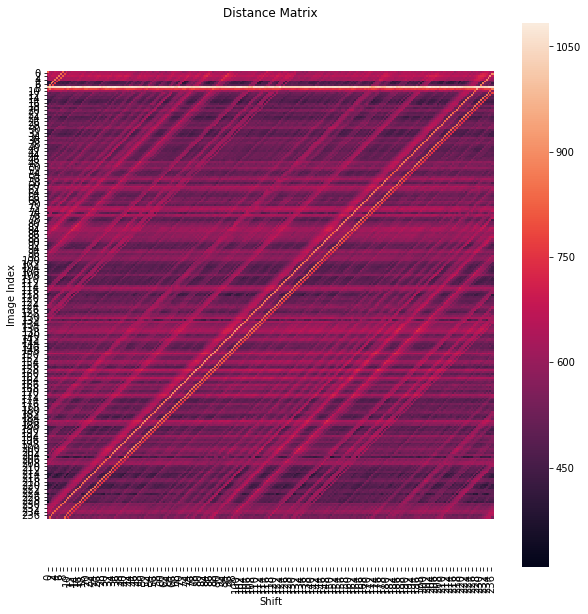

In [6]:
# visualize
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
fig_size = [10,10]
plt.rcParams["figure.figsize"] = fig_size
plt.axis('equal')
ax = sns.heatmap(dst,
                 xticklabels=2,
                 yticklabels=2)
ax.set_xlabel('Shift')
ax.set_ylabel('Image Index')
ax.set_title('Distance Matrix')
plt.show()

### 3. analyse the feature maps

In [7]:
print('Min, Max and Mean of Distances:')
print(np.min(dst), np.max(dst), np.average(dst))
lower, higher = np.min(dst), np.max(dst)

dst_t, dst_f = dst[:,0], dst[:,1:]
#print(dst_t.shape, dst_f.shape)
print('Min, Max and Mean of paired images:', np.min(dst_t), np.max(dst_t), np.mean(dst_t))
print('Min, Max and Mean of unpaired images:', np.min(dst_f), np.max(dst_f), np.mean(dst_f))

print('Sorted distance of paired images:')
print(np.sort(dst_t))

print('First n sorted distance of unpaired images:')
print(np.sort(dst_f.flatten())[:n])

Min, Max and Mean of Distances:
308.69242040508385 1083.2340104148213 563.1597499312354
Min, Max and Mean of paired images: 308.69242040508385 991.0298638473591 498.5740834054776
Min, Max and Mean of unpaired images: 377.92697783196604 1083.2340104148213 563.4322632921036
Sorted distance of paired images:
[308.69242041 315.85148092 357.42560279 361.84390571 367.29753812
 367.86529604 376.79148329 380.178424   387.50141697 389.08328363
 390.27192254 393.29977207 393.85328343 398.47247607 401.59964152
 404.37283309 406.19175956 410.42602801 410.809367   412.9148928
 413.27085962 413.64223374 415.9760338  419.40203813 419.94506146
 420.5000564  420.54800634 420.69033719 422.03649812 422.49617645
 422.70771619 423.67803089 423.73657867 425.05441135 425.7902412
 426.18198767 426.6859559  427.41676598 427.99875284 428.11117104
 428.87994752 429.29253149 429.61177551 430.19941139 431.50087038
 432.1464989  432.29298701 432.29945372 432.43139571 432.49218584
 433.05671352 433.37172376 435.0308

TP, FP, TN, FN, TPR, FPR, Accuracy, Precision, Recall, F1:
(135, 8888, 47518, 103, 0.5672268907563025, 0.1575718895152998, 0.8412718028387826, 0.014961764379917987, 0.5672268907563025, 0.029154518950437316)


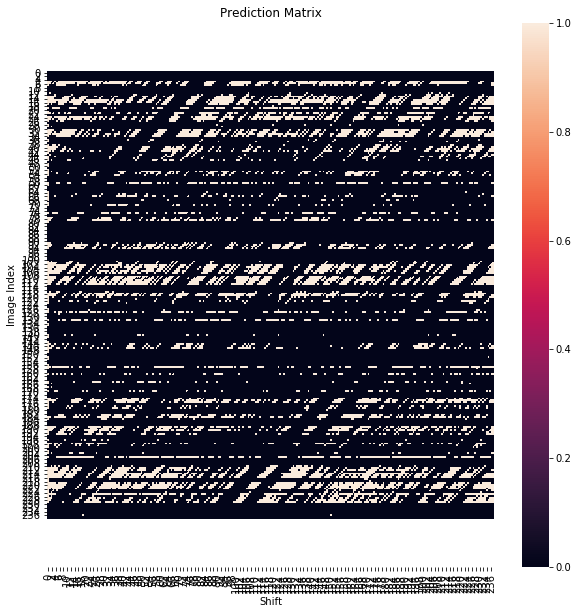

In [8]:
def predict(dst, threshold):
    return (dst <= threshold).astype(np.int)
def ground_truth(dst):
    n = dst.shape[0]
    gt = np.zeros((n,n)).astype(np.int)
    gt[:,0] = 1
    return gt
def confusion_matrix(pred, gt):
    n = gt.shape[0]
    TP = np.sum(gt[:,0] == pred[:,0])
    FN = np.sum(gt[:,0] != pred[:,0])
    TN = np.sum(gt[:,1:] == pred[:,1:])
    FP = np.sum(gt[:,1:] != pred[:,1:])
    TPR=TP/(TP+FN)
    FPR=FP/(FP+TN)
    ACC = (TP+TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*precision*recall/(precision+recall)
    return TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1

threshold = 500
pred = predict(dst, threshold)
gt = ground_truth(dst)

print("TP, FP, TN, FN, TPR, FPR, Accuracy, Precision, Recall, F1:")
print(confusion_matrix(pred, gt))
#%matplotlib inline
plt.axis('equal')
ax = sns.heatmap(pred,
                 xticklabels=2,
                 yticklabels=2)
ax.set_xlabel('Shift')
ax.set_ylabel('Image Index')
ax.set_title('Prediction Matrix')
plt.show()

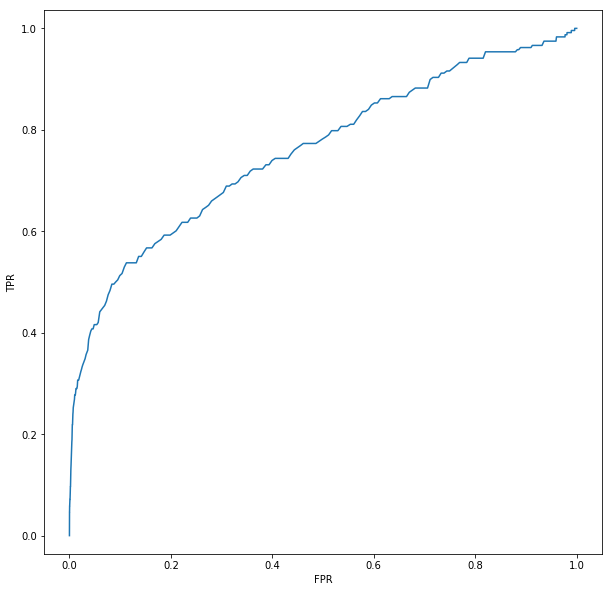

In [9]:
# Draw ROC curve
np.seterr(divide='ignore',invalid='ignore')
ROC_x, ROC_y = [0], [0]
for threshold in range(int(lower),int(higher)+1):
    pred = predict(dst, threshold)
    gt = ground_truth(dst)
    conf_mat = confusion_matrix(pred, gt)
    x, y = conf_mat[5], conf_mat[4] # x: FPR, y: TPR
    ROC_x.append(x)
    ROC_y.append(y)
ROC_x.append(1)
ROC_y.append(1)
#%matplotlib inline
plt.plot(ROC_x, ROC_y)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis('equal')
plt.show()